# Subspace Digital Twin, Parameter Selection Under Uncertainty

*BlockScience, April 2024*

Here we execute the PSUU framework for the subspace economic model.

## Summary 

This parameter selection under uncertainty process evaluates simulation trajectories according to a set of KPIs for the subspace economic system. Utiliy is visualized per KPI per parameter using decision trees, histograms, scatter plots, and line plots, which can be used together to indicate relationships between parameter selections and KPI outcomes to the analyst.

For more information see the methodology document: https://hackmd.io/iFeP7NemRH--KtWbPP_W0w?view


## Contents
**Experimental Setup**: An overview of the PSUU methodology applied to The Subspace Economic Model. For more information on the PSUU methodology see the document linked above.

**PSUU Dataset**: This section loads the required components from the psuu subpackage and loads the latest psuu dataset. 

**KPI Results Aggregated by Trajectory**: KPIs are calculated by grouping trajectories and applying KPI functions.

**Utility Outcomes by Trajectory**: Utility is computed per KPI per trajectory, each on the criteria specified for that KPI. Criteria can be defined as a KPI value being less than the median or bigger than the median for that KPI across all trajectories.

**Decision Tree and Parameter Importance**: Using the utility tensor, a machine-learning process is applied to infer the importance of different parameters on the associated KPI-based threshold inequalities. This provides a method of assessing whether one or more parameters are 'crucial' to success, in the sense that they have an outsized impact on the success criteria. This approach leverages decision trees that are fit to the results of the entire utility tensor.

**Parameter Impact on KPIs**: A density approach (histogram) can be used to assess the impact of protocol parameters on the KPIs of the scenario. The KPI densities are shown for each protocol parameter sweep value, providing a visual indication of the impact of the parameter on the density shape and location.

**Conclusion**: An overall assessment of the scenario results is provided, highlighting any problems, caveats, implications and possibilities for future/extended work.

## Experimental Setup

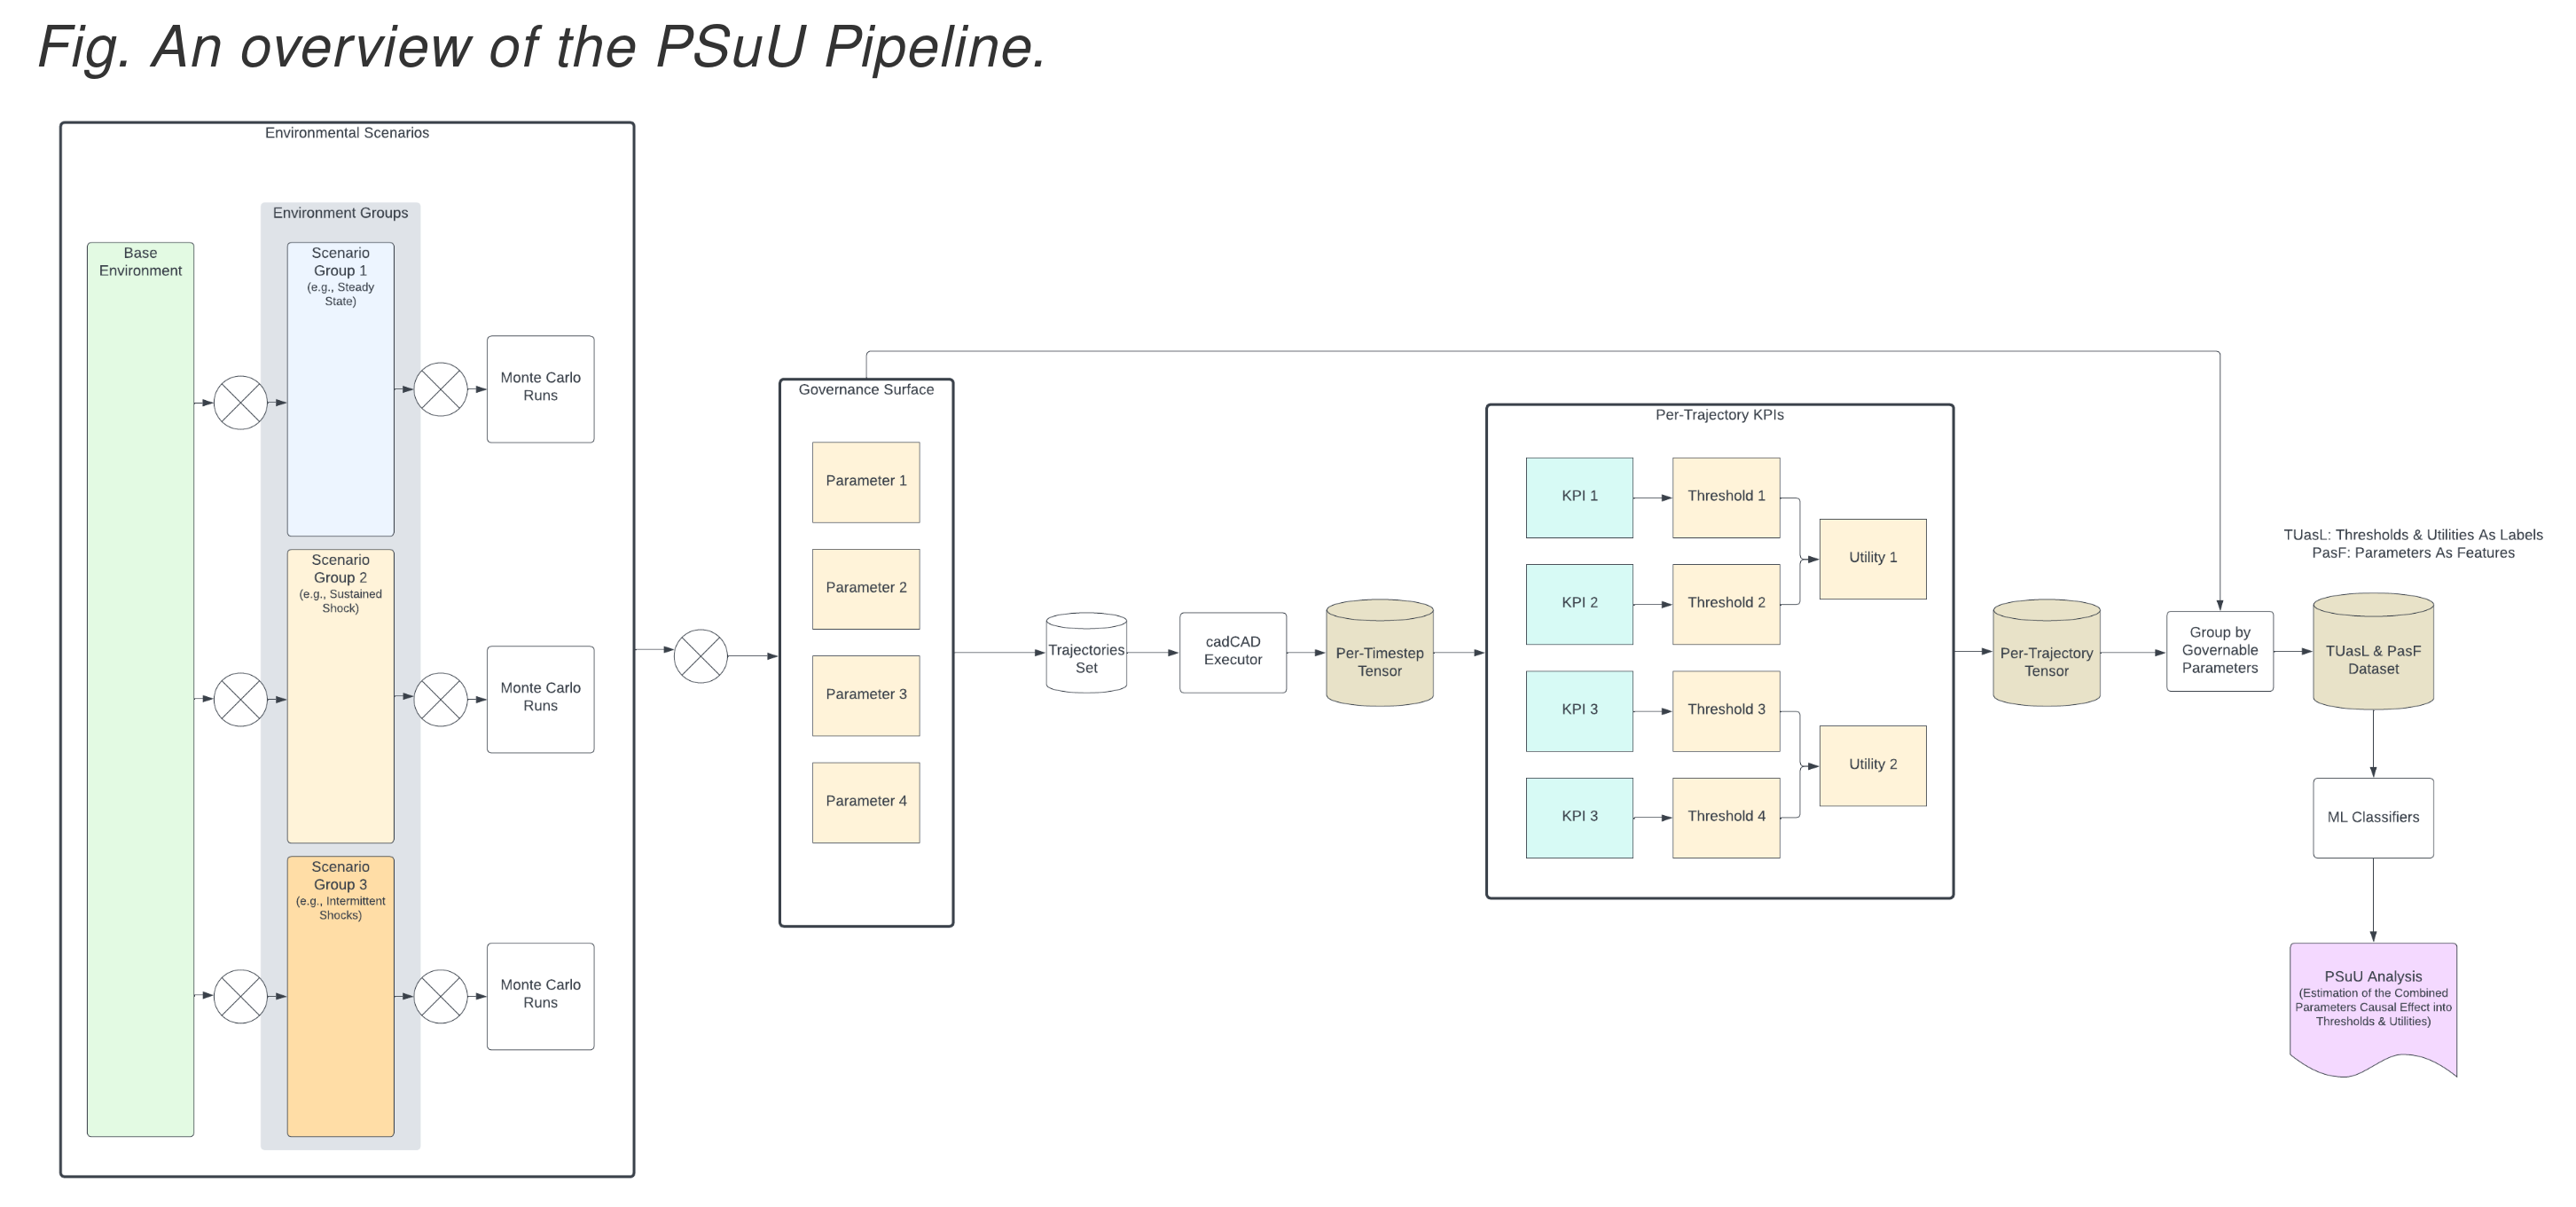

### An overview of the PSUU methodology. 

Simulation trajectories are collected by running simulations for particular parameter sets. Parameter sets, known as sweeps, are sampled from the cartesian product of controllable parameters and environmental scenarios. For each trajectory, KPIs are computed, and decision trees are generated that map parameter selection to KPI outcomes. Density plots are used to further show relationships between parameter selection and KPI outcomes. Finally, a conclusion is provided by the analyst to serve the subspace team in navigating system implementation and laying the ground for future research by the team.

### The core components of PSUU:
- Workflow
- Goals and associated KPIS
- Governance Surface (Controllable Parameters)
- Environmental Scenarios
- Results Analysis

### Workflow

In the PSUU workflow, simulation datasets are generated by running a command like the following in your terminal: 

```bash
python -m subspace_model -e psuu -s 3 -sw 26000
```
The above command runs the PSUU workflow with 3 monte carlo samples per parameter set, and samples 26000 parameter sets from the parameter sweep space.

The above command will populate the directory `subspace/data/simulations/` with files of the form `psuu_run_{YYYY-MM-DD}T{HH:MM:SS}Z-{PART}.pkl.gz` where the timestamp will be consistent for a single dataset, and each dataset will be composed of multiple parts.

### Goals and Associated KPIs
- Goal 1: Rational Economic Incentives
- Goal 2: Community Incentives
- Goal 3: Supply Demand Equilibrium

**G1: Rational Economic Incentives**

    KPI: mean_proposing_rewards_per_newly_pledged_space
        Threshold: Larger than median

    KPI: mean_proposer_reward_minus_voter_reward
        Threshold: Larger than median

**G2: Community Incentives**

    KPI: per_timestep_average_relative_community_owned_supply
        Threshold: Larger than median

    KPI: cumm_rewards_before_1yr
        Threshold: Larger than median

**G3: Supply Demand Equilibrium**

    KPI: mean_farmer_subsidy_factor
        Threshold: Smaller than median

    KPI: abs_sum_storage_fees_per_sum_compute_fees
        Threshold: Smaller than median

    KPI: cumm_rewards
        Threshold: Smaller than median

### Governance Surface (Controllable Parameters)

    Component 1:
        Initial period start
        Initial period duration
        Max reference subsidy
        Max cumulative subsidy

    Component 2:
        Initial period start
        Initial period duration
        Max reference subsidy
        Max cumulative subsidy

    Reward proposer share
    Weight to fee

### Environmental Scenarios
Environmental scenarios are designed to test the system over fluctuation of the following environmental behaviours:
- utilization ratio: means: [0.005, 0.01, 0.02]
- priority fee: means: [0]
- slash per day: means: [0]
- operator stake per transaction: means: [0.1]
- nominator stake per transaction: means: [0.1]
- transfers from farmers to holder per day: means: [1]
- transfers from operators to holders per day function: means: [0.1]
- transfer from holders to nominators per day: means: [0.025]
- transfer from holders to operators per day: means: [0.025]

### Results Analysis
Results are analyzed in the remainder of this notebook. Results can be analyzed in the following forms:
* Trajectory Summary Statistics
* Parameter KPI Decision Trees
* Parameter KPI Density Plots
* Parameter KPI Impact Analysis

Effects of a parameter onto a KPI can be categorized as one of the following:
* Positively Correlated
* Negatively Correlated
* Uncorrelated
* Inconclusive 

## Import Dependencies

In [1]:
%matplotlib inline
import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

import matplotlib
# Third Party Libraries
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import hvplot.pandas
import holoviews as hv
from typing import Callable, Dict, List, Tuple, Union

# Subspace Model Package
import sys
sys.path.append('../../')
from subspace_model.psuu.plots import create_decision_tree_importances_plot
from subspace_model.psuu import timestep_tensor_to_trajectory_tensor, GOVERNANCE_SURFACE_PARAMS
from subspace_model.psuu.kpis import KPI_functions, calculate_goal_score, GOAL_KPI_GROUPS

## PSUU Dataset

Try to load an entire timestep tensor. This step is not recommended when working with very large simulation datasets. It's better to aggregate KPIs by parts which is seen in the next section.

In [2]:
# pd.set_option('display.max_columns', None)

# psuu_files = sorted(glob("../../data/simulations/psuu-2024*"))

# if len(psuu_files):
    
#     latest = psuu_files[-1]

#     sim_df = pd.read_pickle(latest, compression='gzip')
    
#     N_sweeps = len(sim_df.subset.unique())
#     N_runs = len(sim_df.run.unique())
#     N_trajectories = N_sweeps * N_runs
#     N_timesteps = len(sim_df.timestep.unique())
#     N_measurements = N_trajectories * N_timesteps
    
#     print(f"Tensor Size: {N_measurements=:,} over {N_trajectories=:,} | ({N_sweeps=:,}, {N_runs=:,}, {N_timesteps=:,})\t")
# else:
#     print("PSUU not loaded. Try loading by parts.")

Load the trajectory tensor directly. This is prefered.

In [3]:
# try:
#     agg_df = pd.read_pickle('../../data/trajectory_tensors/2024-04-24T05:57:17Z.pkl.gz', compression='gzip')
# except:
#     if len(psuu_files):
#         agg_df = timestep_tensor_to_trajectory_tensor(sim_df).reset_index()
#         agg_df.set_index(GOVERNANCE_SURFACE_PARAMS+['subset', 'run']).describe()
#     else:
#         print("PSUU not loaded. You will have to run a simulation.")


agg_df = pd.read_pickle('s3://subspace-simulations/psuu_run-2024-04-24T18:36:05Z/trajectory_tensor.pkl.gz', compression='gzip')


## KPI Results Aggregated by Trajectory

This section provides a dataset that is indexed by simulation run and controllable parameters. The dataset contains KPI outcomes per trajectory. In other words, it has KPIs as columns, and trajectories as an index. It is a much smaller dataset than the PSUU dataset because it is aggregated over timesteps. Given that simulations are running for 3 years, the trajectory tensor is roughly 1/1000 times the size of the original psuu dataset.  

In [4]:
agg_df

index  simulation  subset  run  component_1_max_cumulative_subsidy  \
0       0           0      40    1                         113460000.0   
1       1           0      40    2                         113460000.0   
2       2           0      41    1                         113460000.0   
3       3           0      41    2                         113460000.0   
4       4           0      42    1                         113460000.0   
..    ...         ...     ...  ...                                 ...   
35     35           0     217    2                         189100000.0   
36     36           0     218    1                          37820000.0   
37     37           0     218    2                          37820000.0   
38     38           0     219    1                          37820000.0   
39     39           0     219    2                          37820000.0   

    component_1_initial_period_duration  component_1_initial_period_start  \
0                                     0                                 0   
1                                     0                                 0   
2                                     0                                 0   
3                                     0                                 0   
4                                     0                                14   
..                                  ...                               ...   
35                                    0                                 0   
36                                    0                                 0   
37                                    0                                 0   
38                                    0                                 0   
39                                    0                                 0   

    component_2_max_cumulative_subsidy  component_2_initial_period_start  \
0                          189100000.0                                30   
1                          189100000.0                                30   
2                          189100000.0                                 0   
3                          189100000.0                                 0   
4                          113460000.0                                 0   
..                                 ...                               ...   
35                          37820000.0                                30   
36                         189100000.0                                14   
37                         189100000.0                                14   
38                         113460000.0                                14   
39                         113460000.0                                14   

    weight_to_fee  ...  component_2_initial_period_duration  \
0    1.000000e-16  ...                           21024000.0   
1    1.000000e-16  ...                           21024000.0   
2    1.000000e-15  ...                           21024000.0   
3    1.000000e-15  ...                           21024000.0   
4    1.000000e-15  ...                            5256000.0   
..            ...  ...                                  ...   
35   1.000000e-16  ...                            2628000.0   
36   1.000000e-14  ...                           21024000.0   
37   1.000000e-14  ...                           21024000.0   
38   1.000000e-16  ...                            2628000.0   
39   1.000000e-16  ...                            2628000.0   

    component_1_max_reference_subsidy  reward_proposer_share  \
0                                   7               0.333333   
1                                   7               0.333333   
2                                   7               0.100000   
3                                   7               0.100000   
4                                   4               0.100000   
..                                ...                    ...   
35                                  7               0.333333   
36      

In [5]:
agg_df.reset_index()

level_0  index  simulation  subset  run  \
0           0      0           0      40    1   
1           1      1           0      40    2   
2           2      2           0      41    1   
3           3      3           0      41    2   
4           4      4           0      42    1   
...       ...    ...         ...     ...  ...   
1995       35     35           0     217    2   
1996       36     36           0     218    1   
1997       37     37           0     218    2   
1998       38     38           0     219    1   
1999       39     39           0     219    2   

      component_1_max_cumulative_subsidy  component_1_initial_period_duration  \
0                            113460000.0                                    0   
1                            113460000.0                                    0   
2                            113460000.0                                    0   
3                            113460000.0                                    0   
4                            113460000.0                                    0   
...                                  ...                                  ...   
1995                         189100000.0                                    0   
1996                          37820000.0                                    0   
1997                          37820000.0                                    0   
1998                          37820000.0                                    0   
1999                          37820000.0                                    0   

      component_1_initial_period_start  component_2_max_cumulative_subsidy  \
0                                    0                         189100000.0   
1                                    0                         189100000.0   
2                                    0                         189100000.0   
3                                    0                         189100000.0   
4                                   14                         113460000.0   
...                                ...                                 ...   
1995                                 0                          37820000.0   
1996                                 0                         189100000.0   
1997                                 0                         189100000.0   
1998                                 0                         113460000.0   
1999                                 0                         113460000.0   

      component_2_initial_period_start  ...  \
0                                   30  ...   
1                                   30  ...   
2                                    0  ...   
3                                    0  ...   
4                                    0  ...   
...                                ...  ...   
1995                                30  ...   
1996                                14  ...   
1997                                14  ...   
1998                                14  ...   
1999                                14  ...   

      component_2_initial_period_duration  component_1_max_reference_subsidy  \
0                              21024000.0                                  7   
1                              21024000.0                                  7   
2                              21024000.0                                  7   
3                              21024000.0                                  7   
4                               5256000.0                                  4   
...                                   ...                                ...   
1995                            2628000.0                                  7   
1996                           21024000.0                                  7   
1997                           21024000.0                                  7   
1998                            2628000.0                                  7   
1999                            2628000.0                     

In [6]:
trajectory_summary_stats_df = agg_df.reset_index().set_index(GOVERNANCE_SURFACE_PARAMS+['subset', 'run']).describe().drop('count')
trajectory_summary_stats_df

level_0      index  simulation  mean_relative_community_owned_supply  \
mean  19.500000  19.500000         0.0                              0.253402   
std   11.546283  11.546283         0.0                              0.028118   
min    0.000000   0.000000         0.0                              0.201646   
25%    9.750000   9.750000         0.0                              0.233760   
50%   19.500000  19.500000         0.0                              0.258372   
75%   29.250000  29.250000         0.0                              0.266872   
max   39.000000  39.000000         0.0                              0.308991   

      mean_farmer_subsidy_factor  \
mean                    0.058048   
std                     0.050738   
min                     0.001263   
25%                     0.016443   
50%                     0.042315   
75%                     0.087520   
max                     0.279447   

      mean_proposing_rewards_per_newly_pledged_space  \
mean                                    7.137201e-13   
std                                     3.465217e-13   
min                                     1.339348e-13   
25%                                     4.796514e-13   
50%                                     7.281872e-13   
75%                                     9.208634e-13   
max                                     1.377724e-12   

      mean_proposer_reward_minus_voter_reward  cumm_rewards_before_1yr  \
mean                             98164.190445             7.986292e+07   
std                              47655.750068             3.568210e+07   
min                              18467.965630             1.578240e+07   
25%                              65944.648943             5.256000e+07   
50%                             100194.857768             8.409600e+07   
75%                             126604.484879             1.155312e+08   
max                             189415.788429             1.471680e+08   

      abs_sum_storage_fees_per_sum_compute_fees  cumm_rewards  
mean                               4.222282e+09  1.957929e+08  
std                                4.404103e+09  9.505156e+07  
min                                4.663068e+07  3.683520e+07  
25%                                9.650897e+08  1.315296e+08  
50%                                2.180318e+09  1.998432e+08  
75%                                6.752314e+09  2.525184e+08  
max                                2.281303e+10  3.777984e+08

Optionally save to disk.

In [7]:
trajectory_summary_stats_df.to_csv('psuu_trajectory_kpis_summarized.csv')

## Utility Outcomes by Trajectory

Evaluating the utility tensor.

In [8]:
# Type alias for a Criterion function
Criterion = Callable[[float, pd.Series], bool]

def evaluate(x: pd.Series, data: pd.DataFrame, success_criteria: Union[str, Criterion]) -> pd.Series:
    col_name = x.name  # Assuming col_name comes from the Series name
    if isinstance(success_criteria, str):
        if success_criteria == 'smaller_than_median':
            y = data.loc[:, col_name] < data.loc[:, col_name].median()
        elif success_criteria == 'larger_than_median':
            y = data.loc[:, col_name] > data.loc[:, col_name].median()
        else:
            raise Exception('Criteria not specified')
    else:
        y = data[col_name].map(lambda z: success_criteria(z, data[col_name]))
    return y

utility_dfs: List[pd.DataFrame] = []
for kpi, (kpi_f, threshold_f) in KPI_functions.items():
    kpi_df = agg_df.reset_index()[[kpi]]
    utility_df = kpi_df.apply(lambda x: evaluate(x, agg_df.reset_index(), threshold_f))
    utility_df.name = kpi
    utility_dfs.append(utility_df)

utility_df: pd.DataFrame = pd.concat(utility_dfs, axis=1).astype(int)
utility_df.index = agg_df.reset_index().set_index(GOVERNANCE_SURFACE_PARAMS+['simulation', 'subset', 'run']).index
utility_df.reset_index(drop=True)

mean_relative_community_owned_supply  mean_farmer_subsidy_factor  \
0                                        1                           1   
1                                        1                           1   
2                                        1                           0   
3                                        1                           0   
4                                        0                           1   
...                                    ...                         ...   
1995                                     1                           1   
1996                                     1                           0   
1997                                     1                           0   
1998                                     1                           1   
1999                                     1                           1   

      mean_proposing_rewards_per_newly_pledged_space  \
0                                                  1   
1                                                  1   
2                                                  1   
3                                                  1   
4                                                  0   
...                                              ...   
1995                                               1   
1996                                               1   
1997                                               1   
1998                                               1   
1999                                               1   

      mean_proposer_reward_minus_voter_reward  cumm_rewards_before_1yr  \
0                                           1                        1   
1                                           1                        1   
2                                           1                        1   
3                                           1                        1   
4                                           0                        0   
...                                       ...                      ...   
1995                                        1                        0   
1996                                        1                        1   
1997                                        1                        1   
1998                                        1                        0   
1999                                        1                        0   

      abs_sum_storage_fees_per_sum_compute_fees  cumm_rewards  
0                                             0             0  
1                                             0             0  
2                                             0             0  
3                                             1             0  
4                                             0             1  
...                                         ...           ...  
1995                                          0             0  
1996                                          1             0  
1997                                          1             0  
1998                                          0             0  
1999                                          0             0  

[2000 rows x 7 columns]

In [9]:
kpi_by_subset = utility_df.groupby('subset').mean()
row_sums = kpi_by_subset.sum(axis=1)
sorted_df = kpi_by_subset.loc[row_sums.sort_values(ascending=False).index]

sorted_df.reset_index(drop=True).hvplot.heatmap(rot=35, height=800, width=800, fontscale=1, cmap='YlGn', title='Sorted Utility outcomes by Parameter Subset', ylabel='Parameter Subset', xlabel='KPI Utility')

:HeatMap   [columns,index]   (value)

## Decision Tree and Parameter Importance

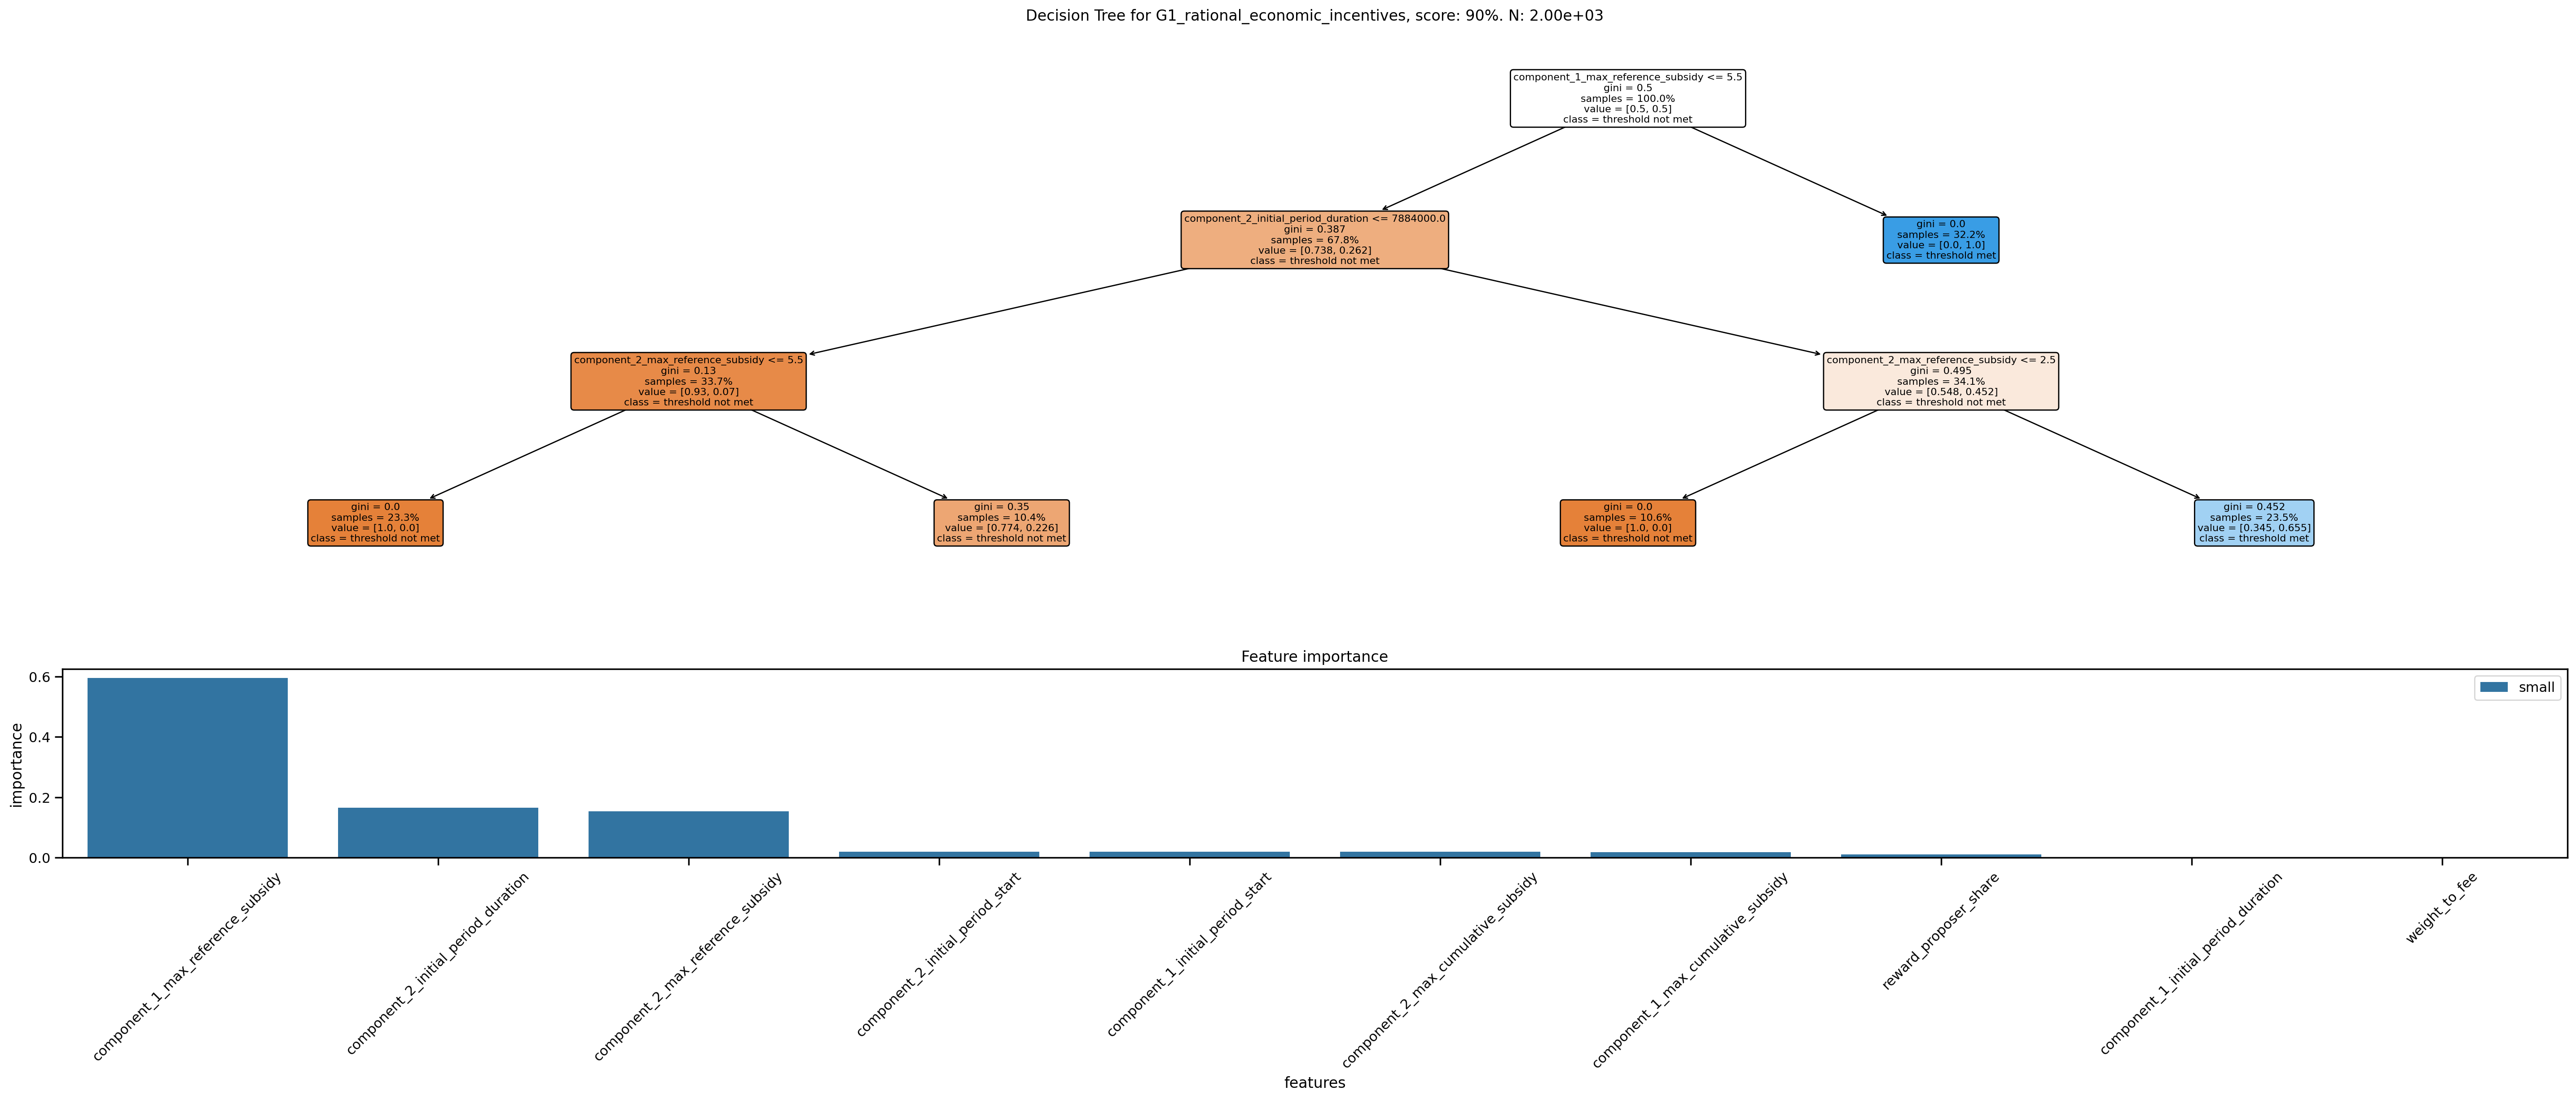

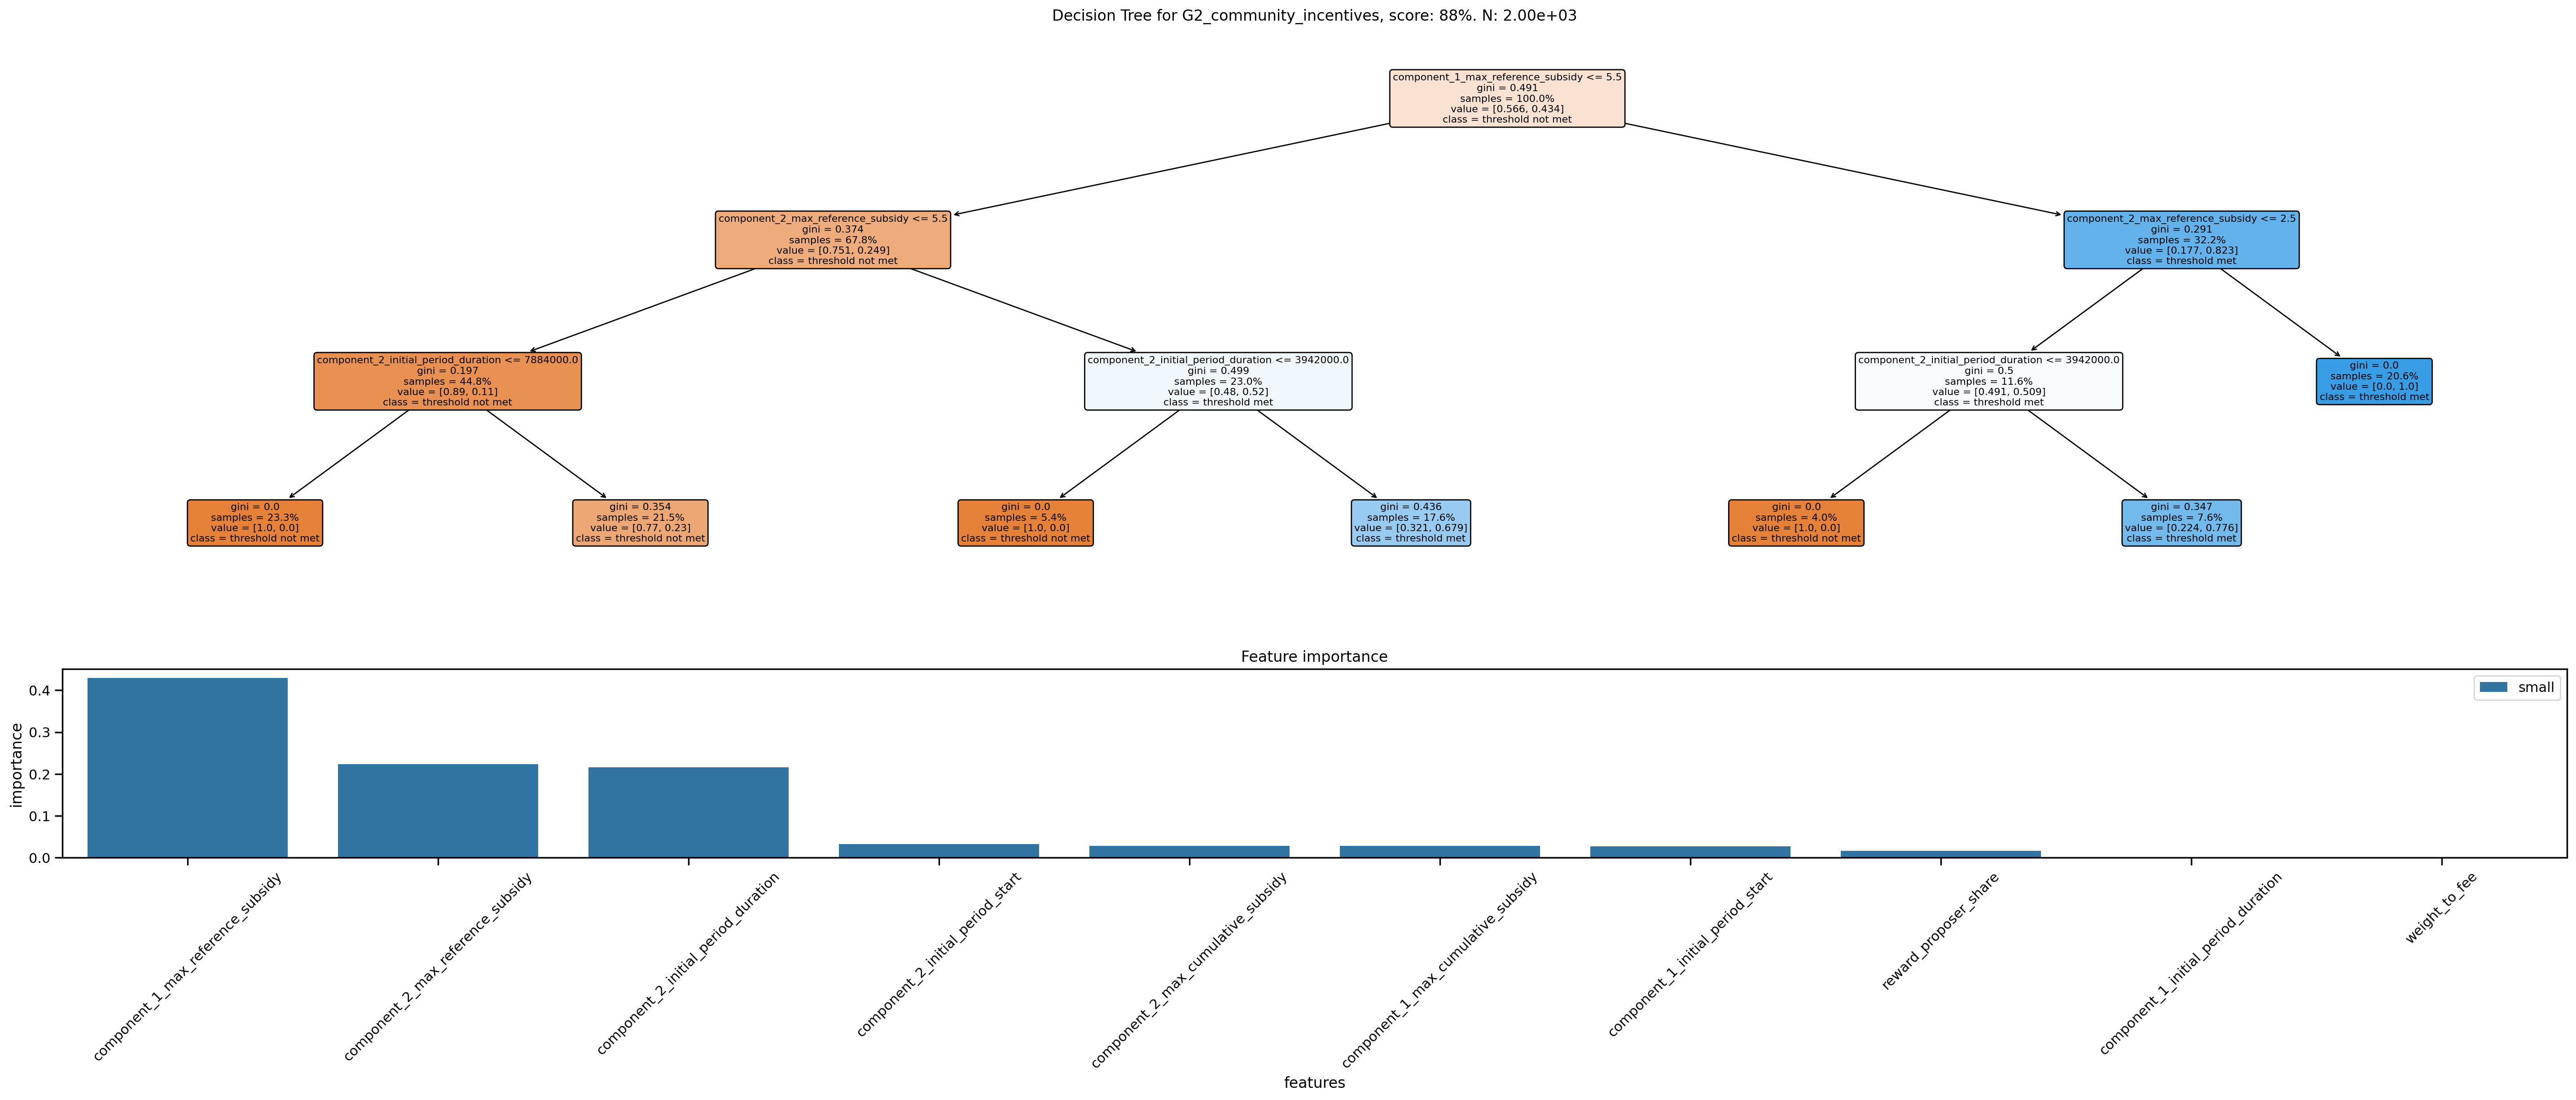

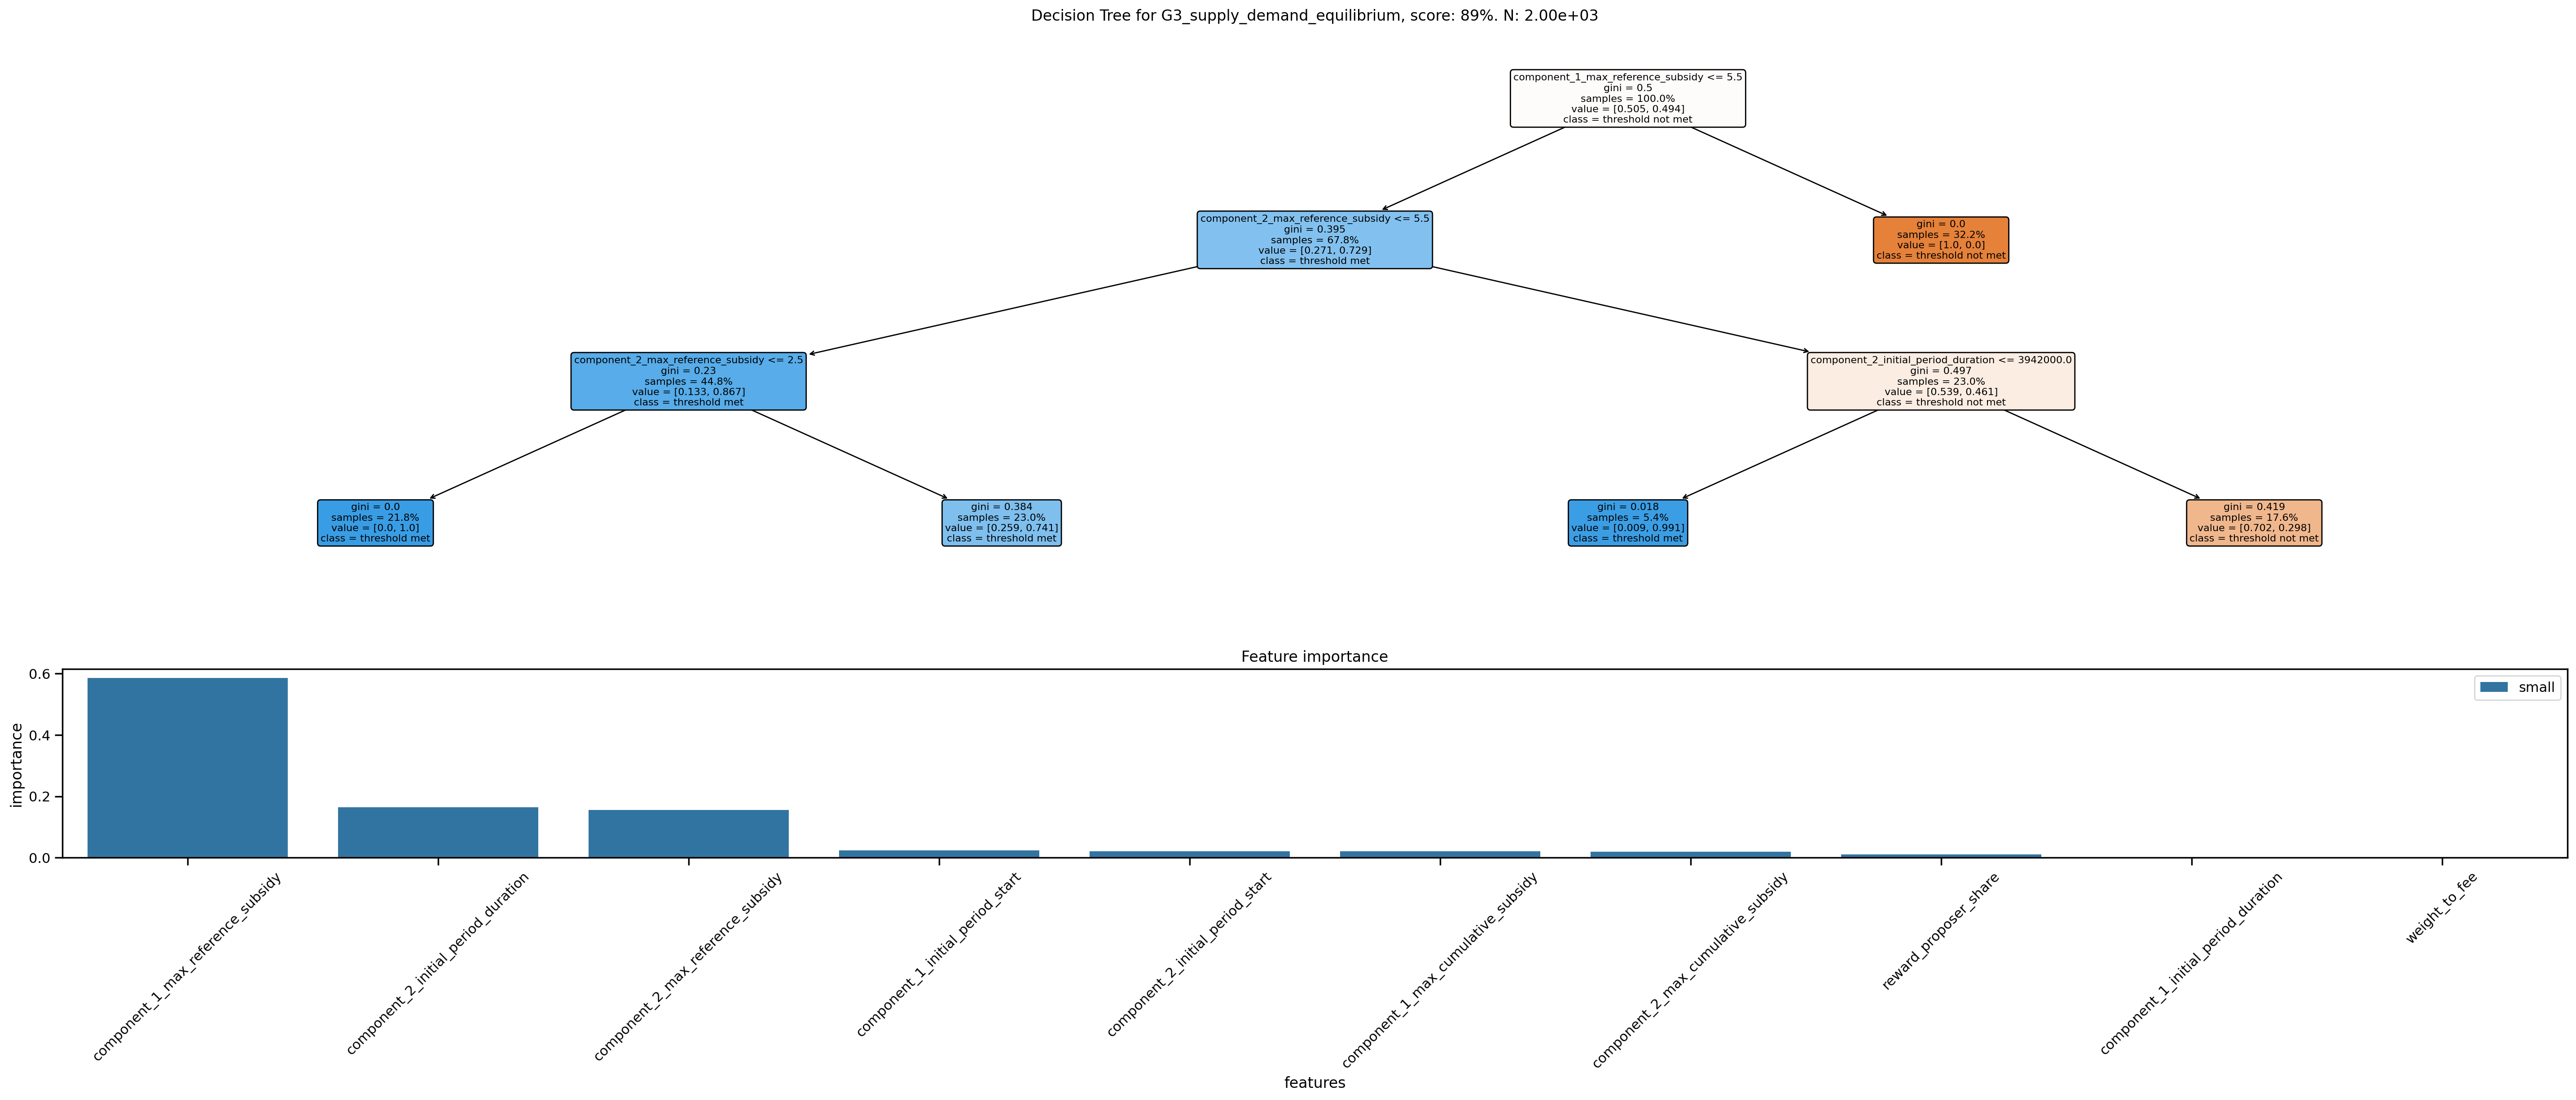

In [10]:
figs_axes = []
for goal, kpis in GOAL_KPI_GROUPS.items():
    goal_df = calculate_goal_score(agg_df.reset_index(), goal, goal)
    fig, axes = create_decision_tree_importances_plot(goal_df, goal, success_criteria='larger_than_median')
    figs_axes.append((fig,axes))

In [11]:
import io

In [12]:
fig = figs_axes[0][0]

In [13]:
buf = io.BytesIO()
fig.savefig(buf, format='png')
buf.seek(0)  # Go to the start of the buffer
print(f"Size of buffer: {int(len(buf.getvalue())/1e3)}KB")  # Print size in bytes
buf.close()

Size of buffer: 165KB


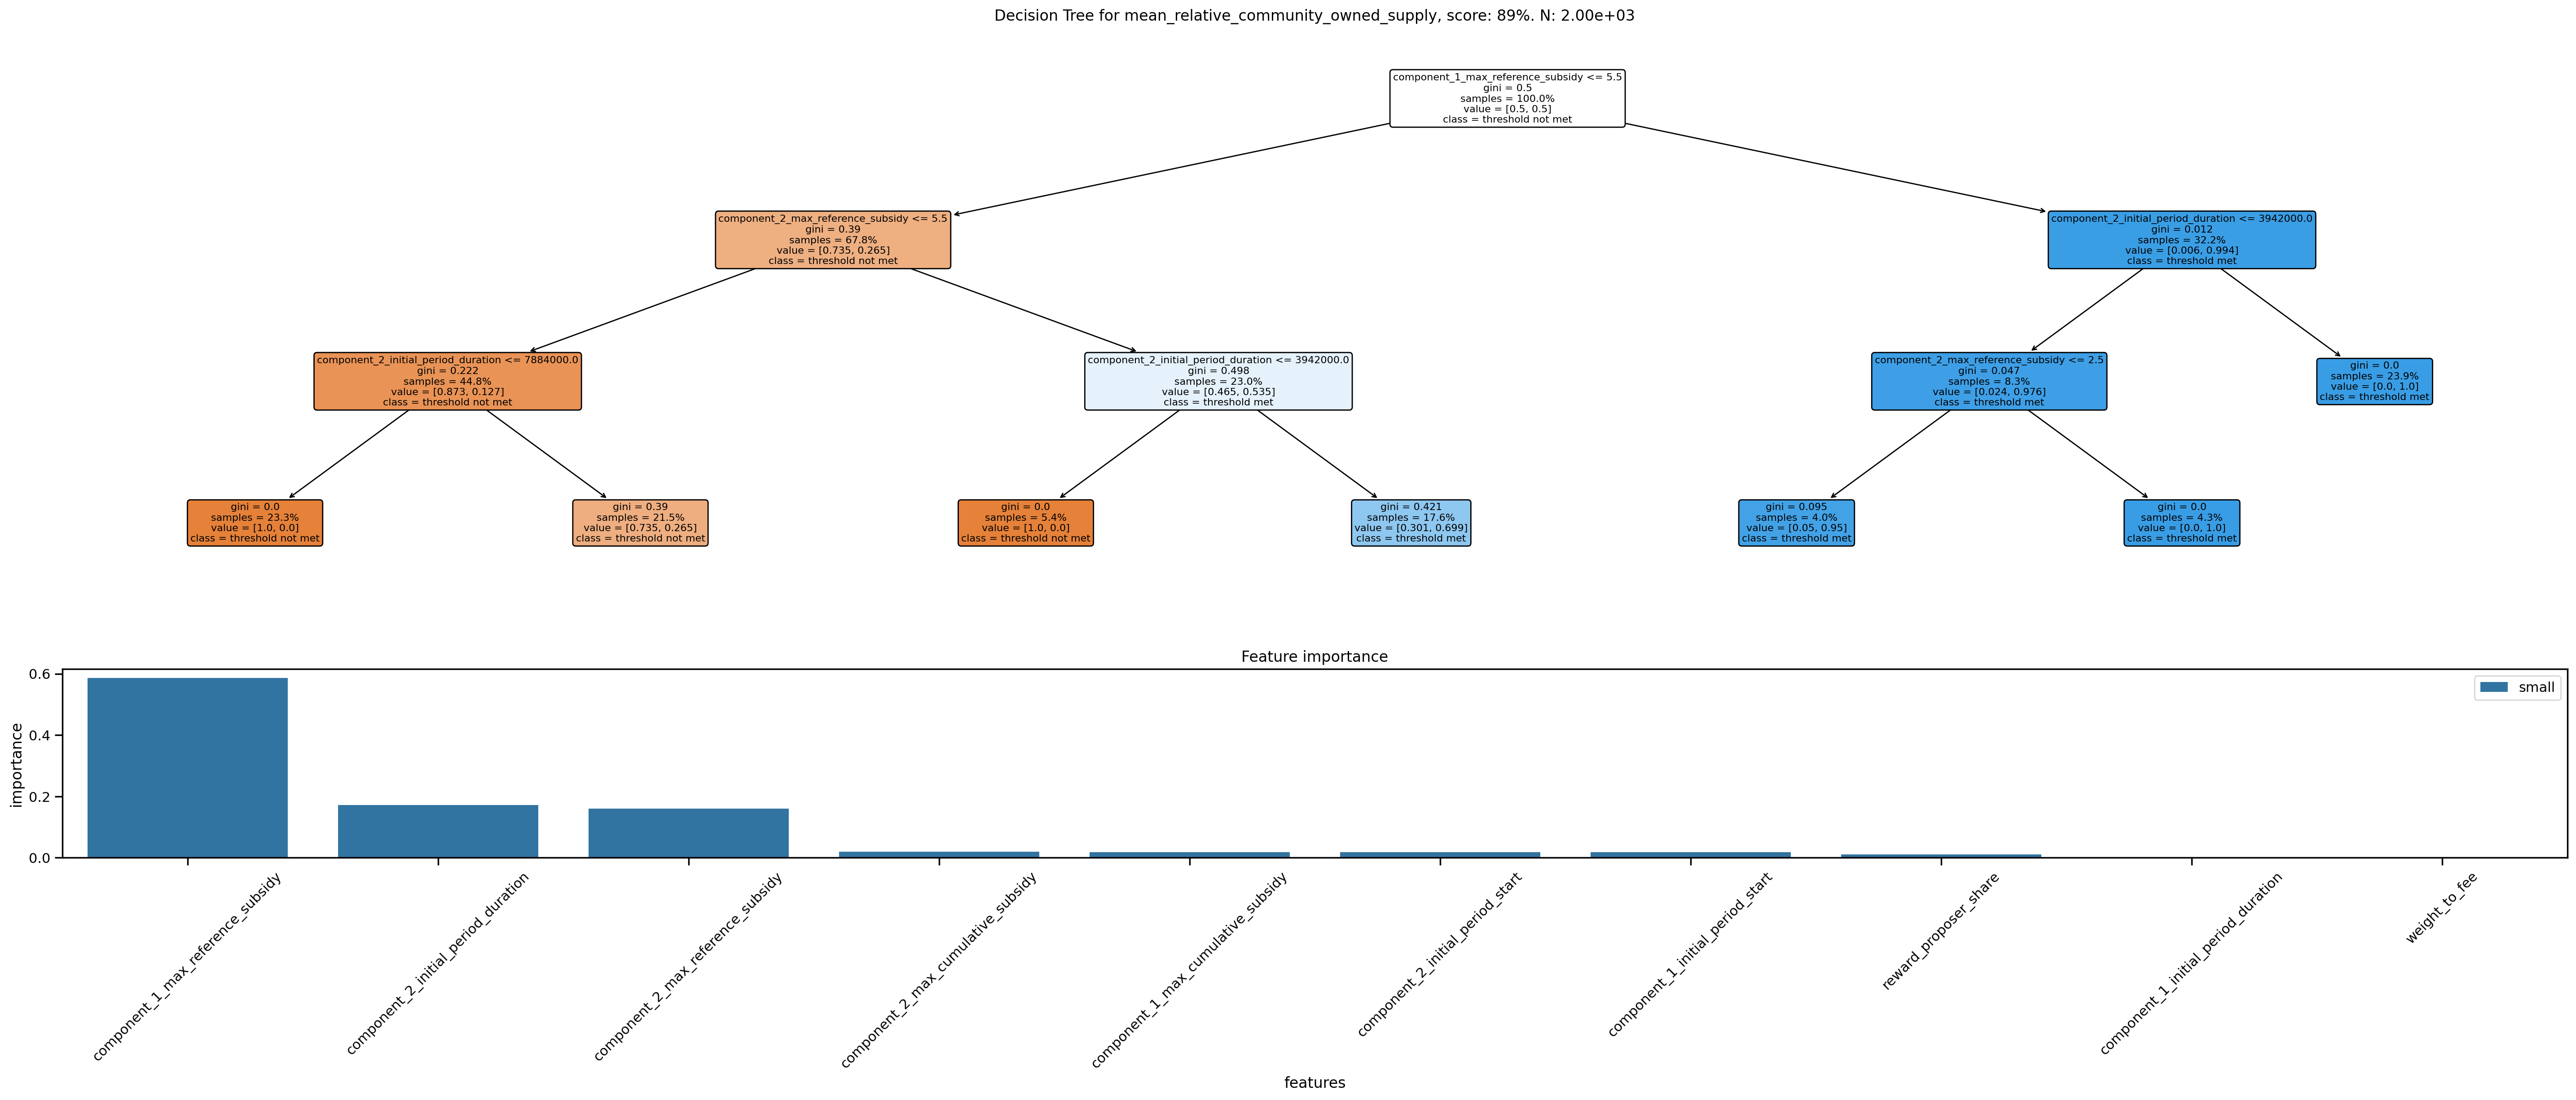

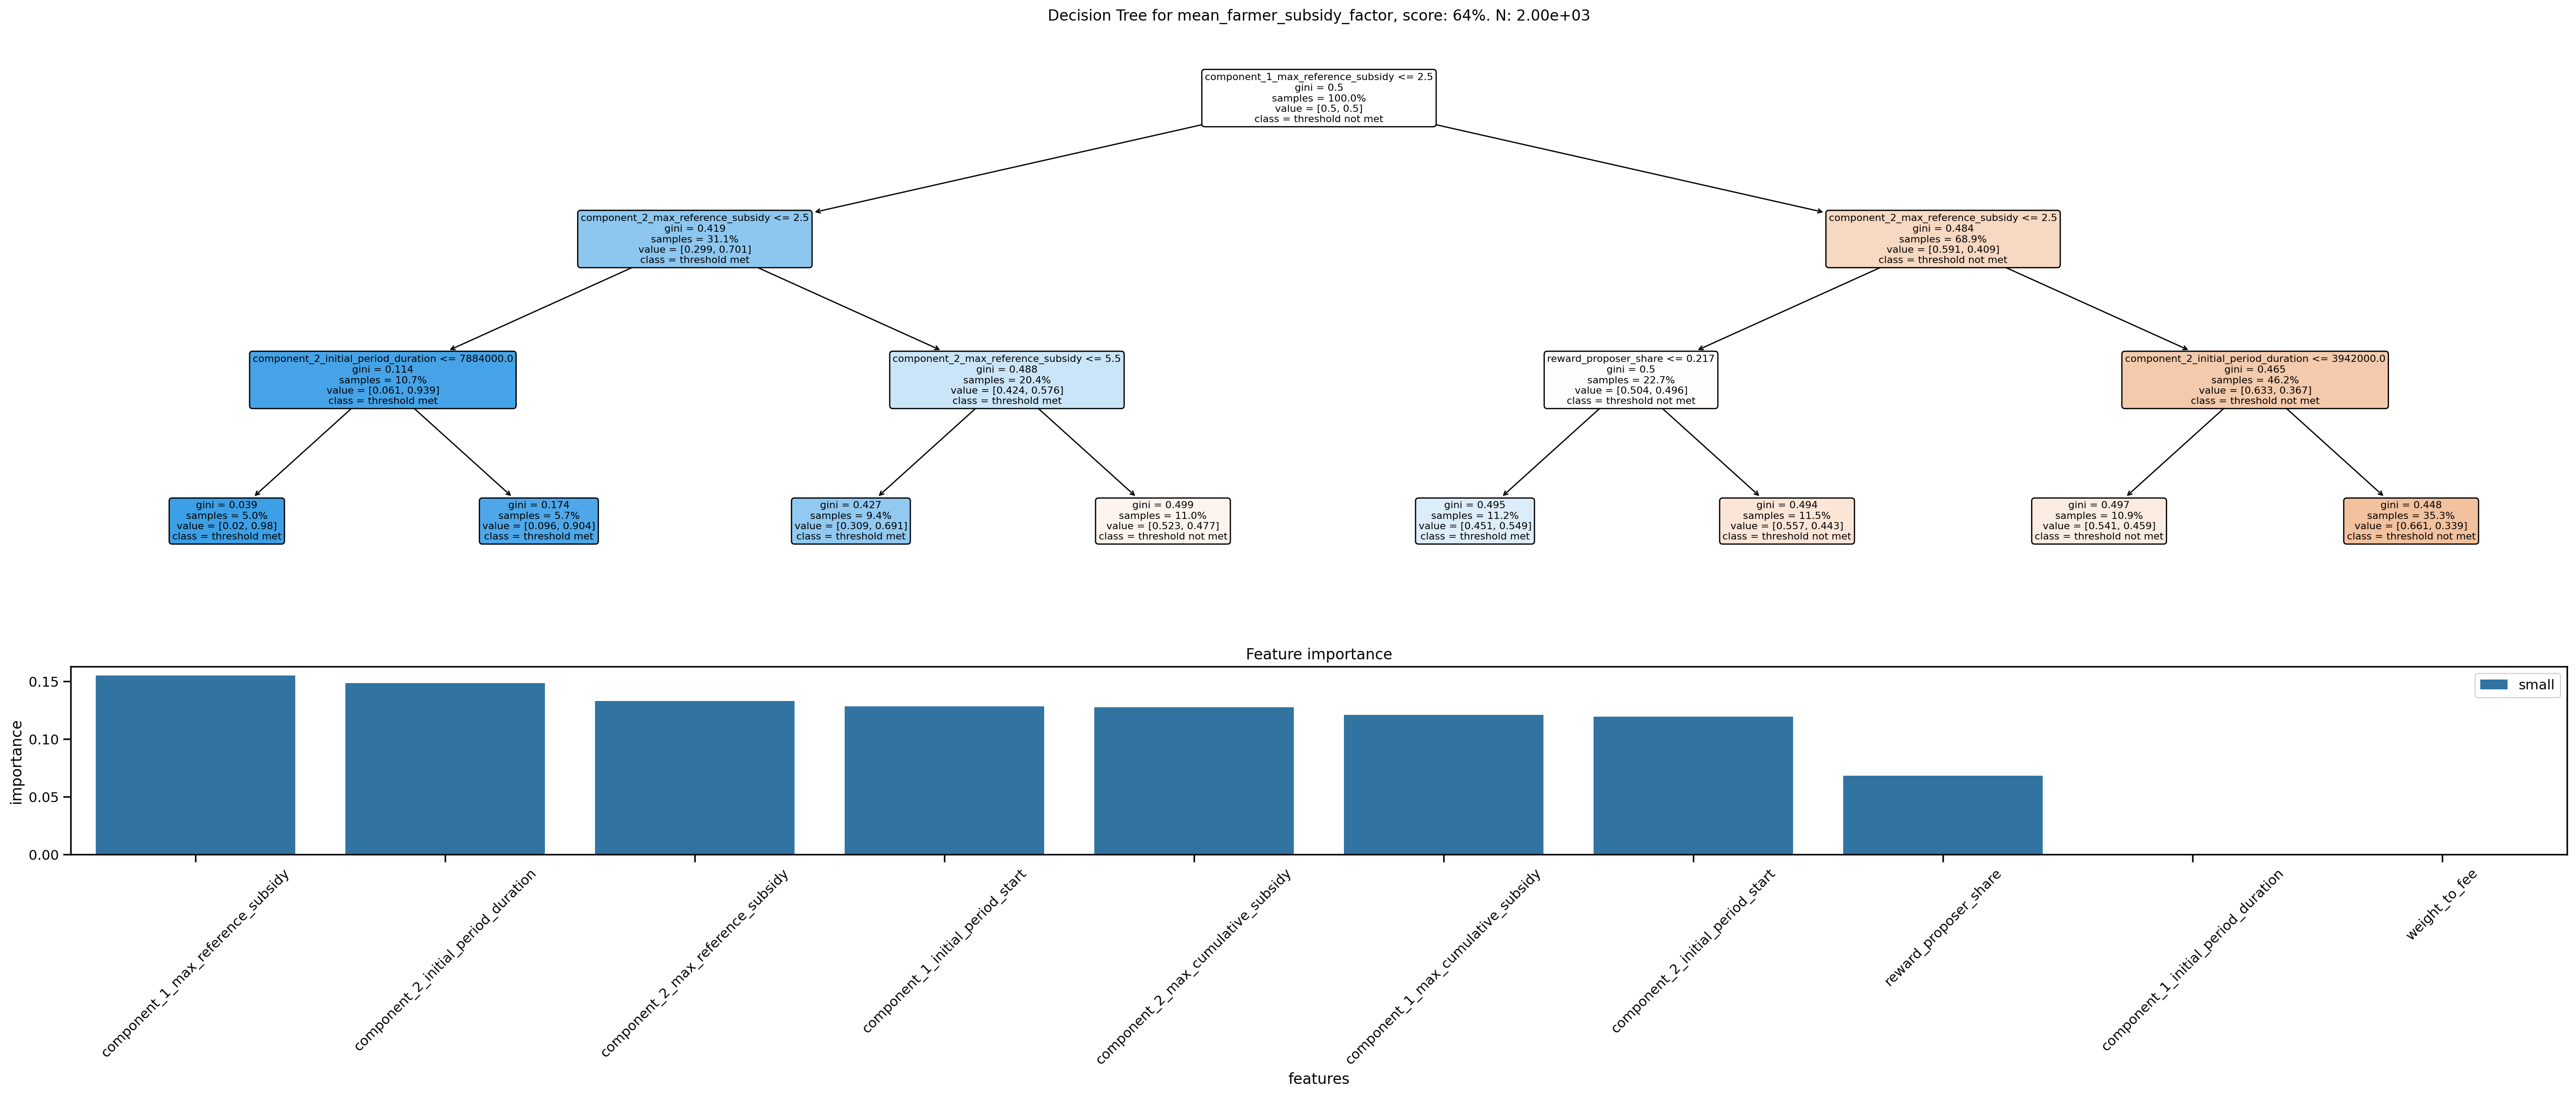

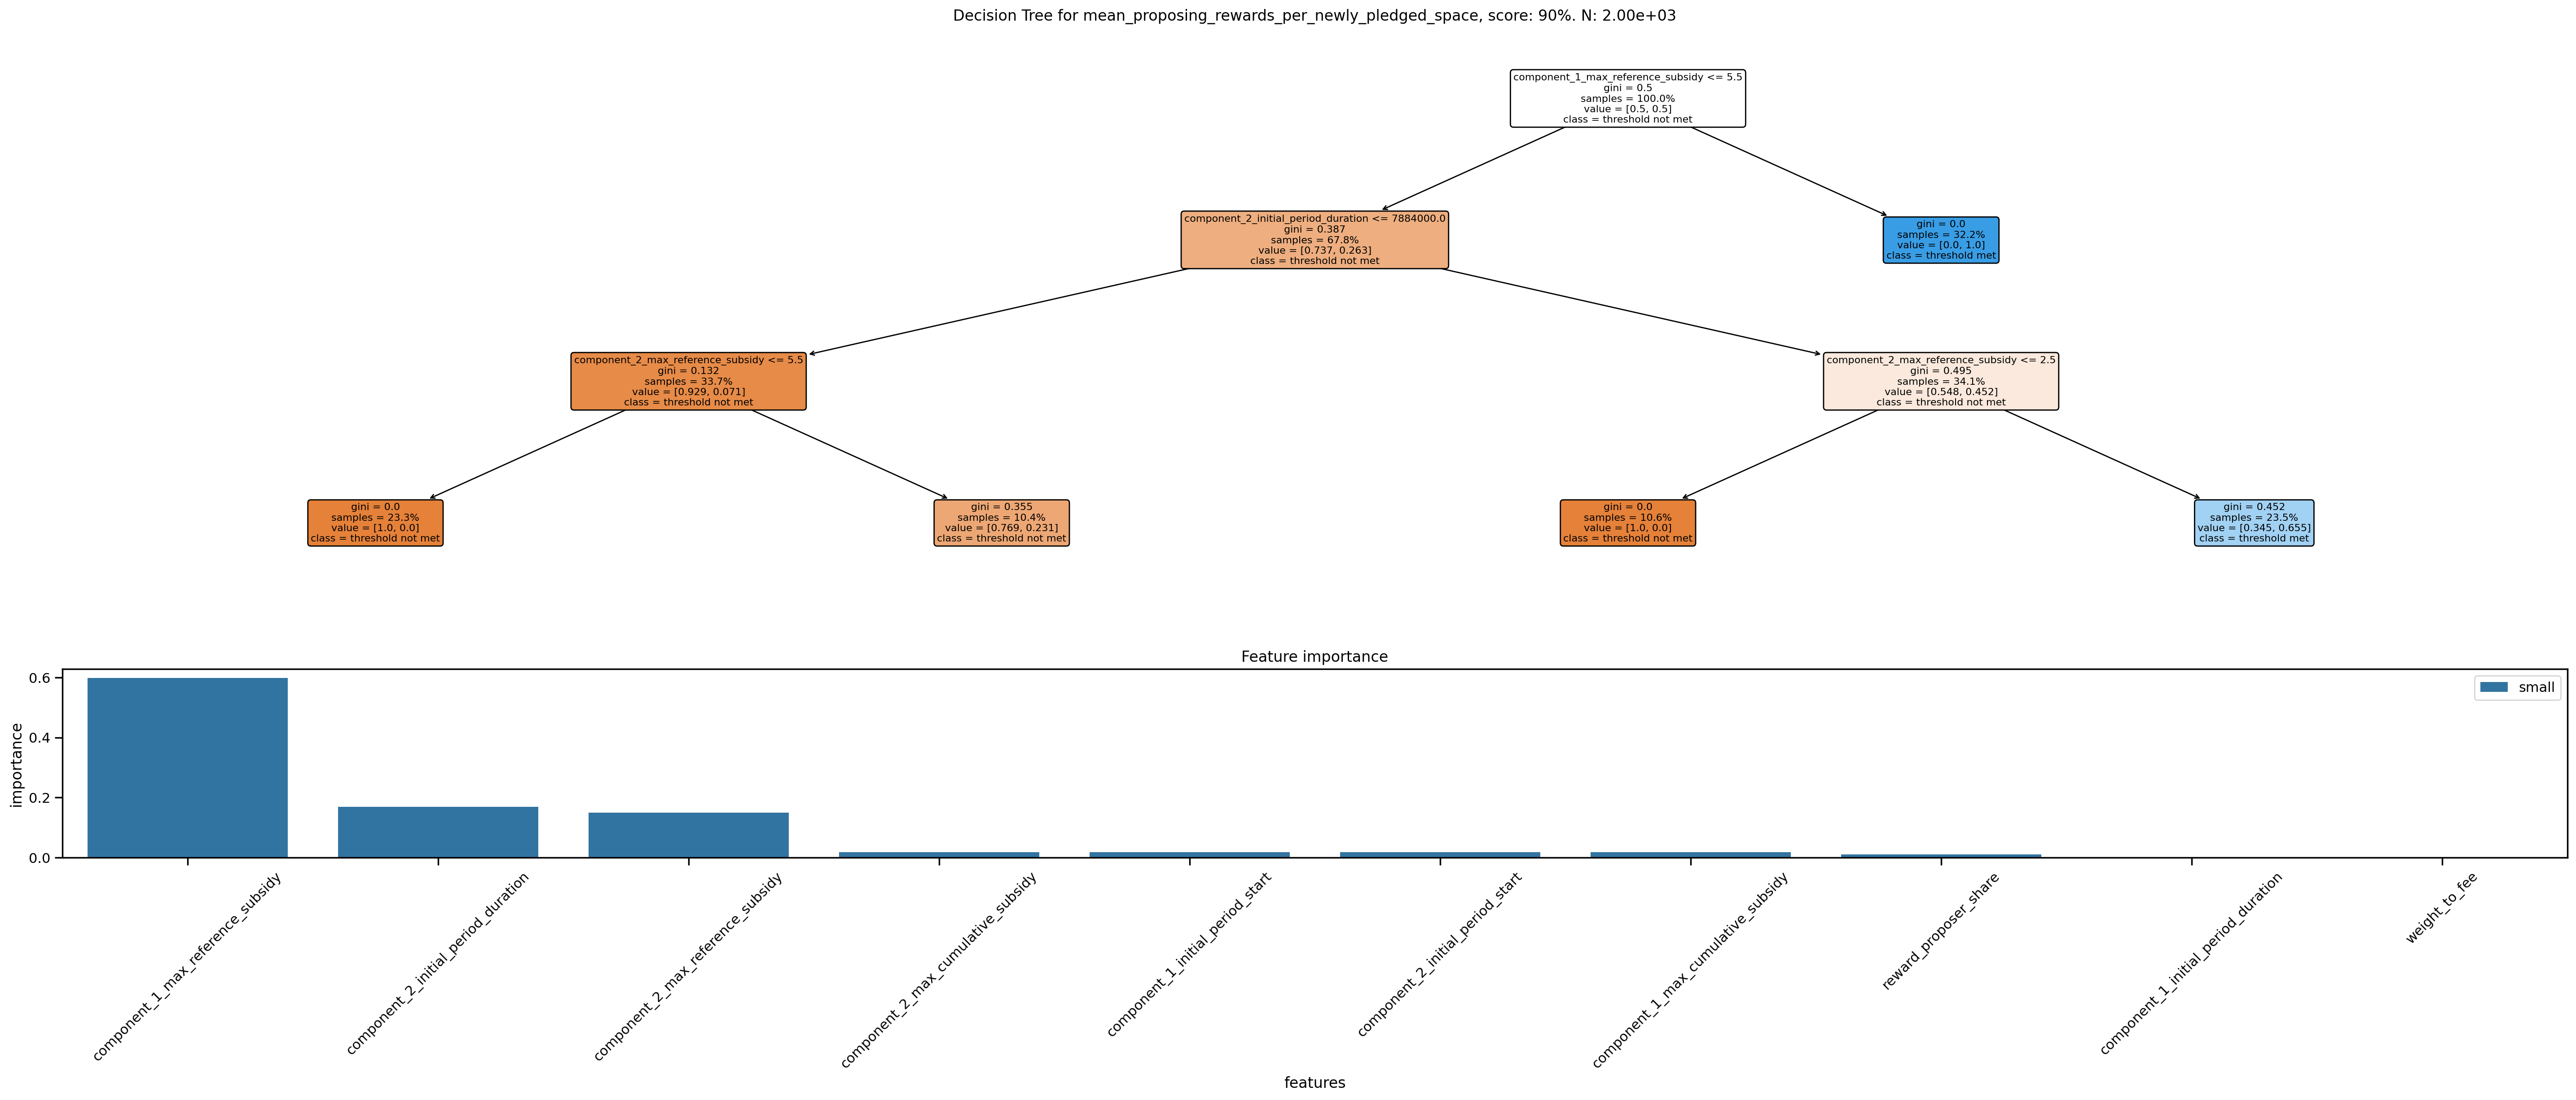

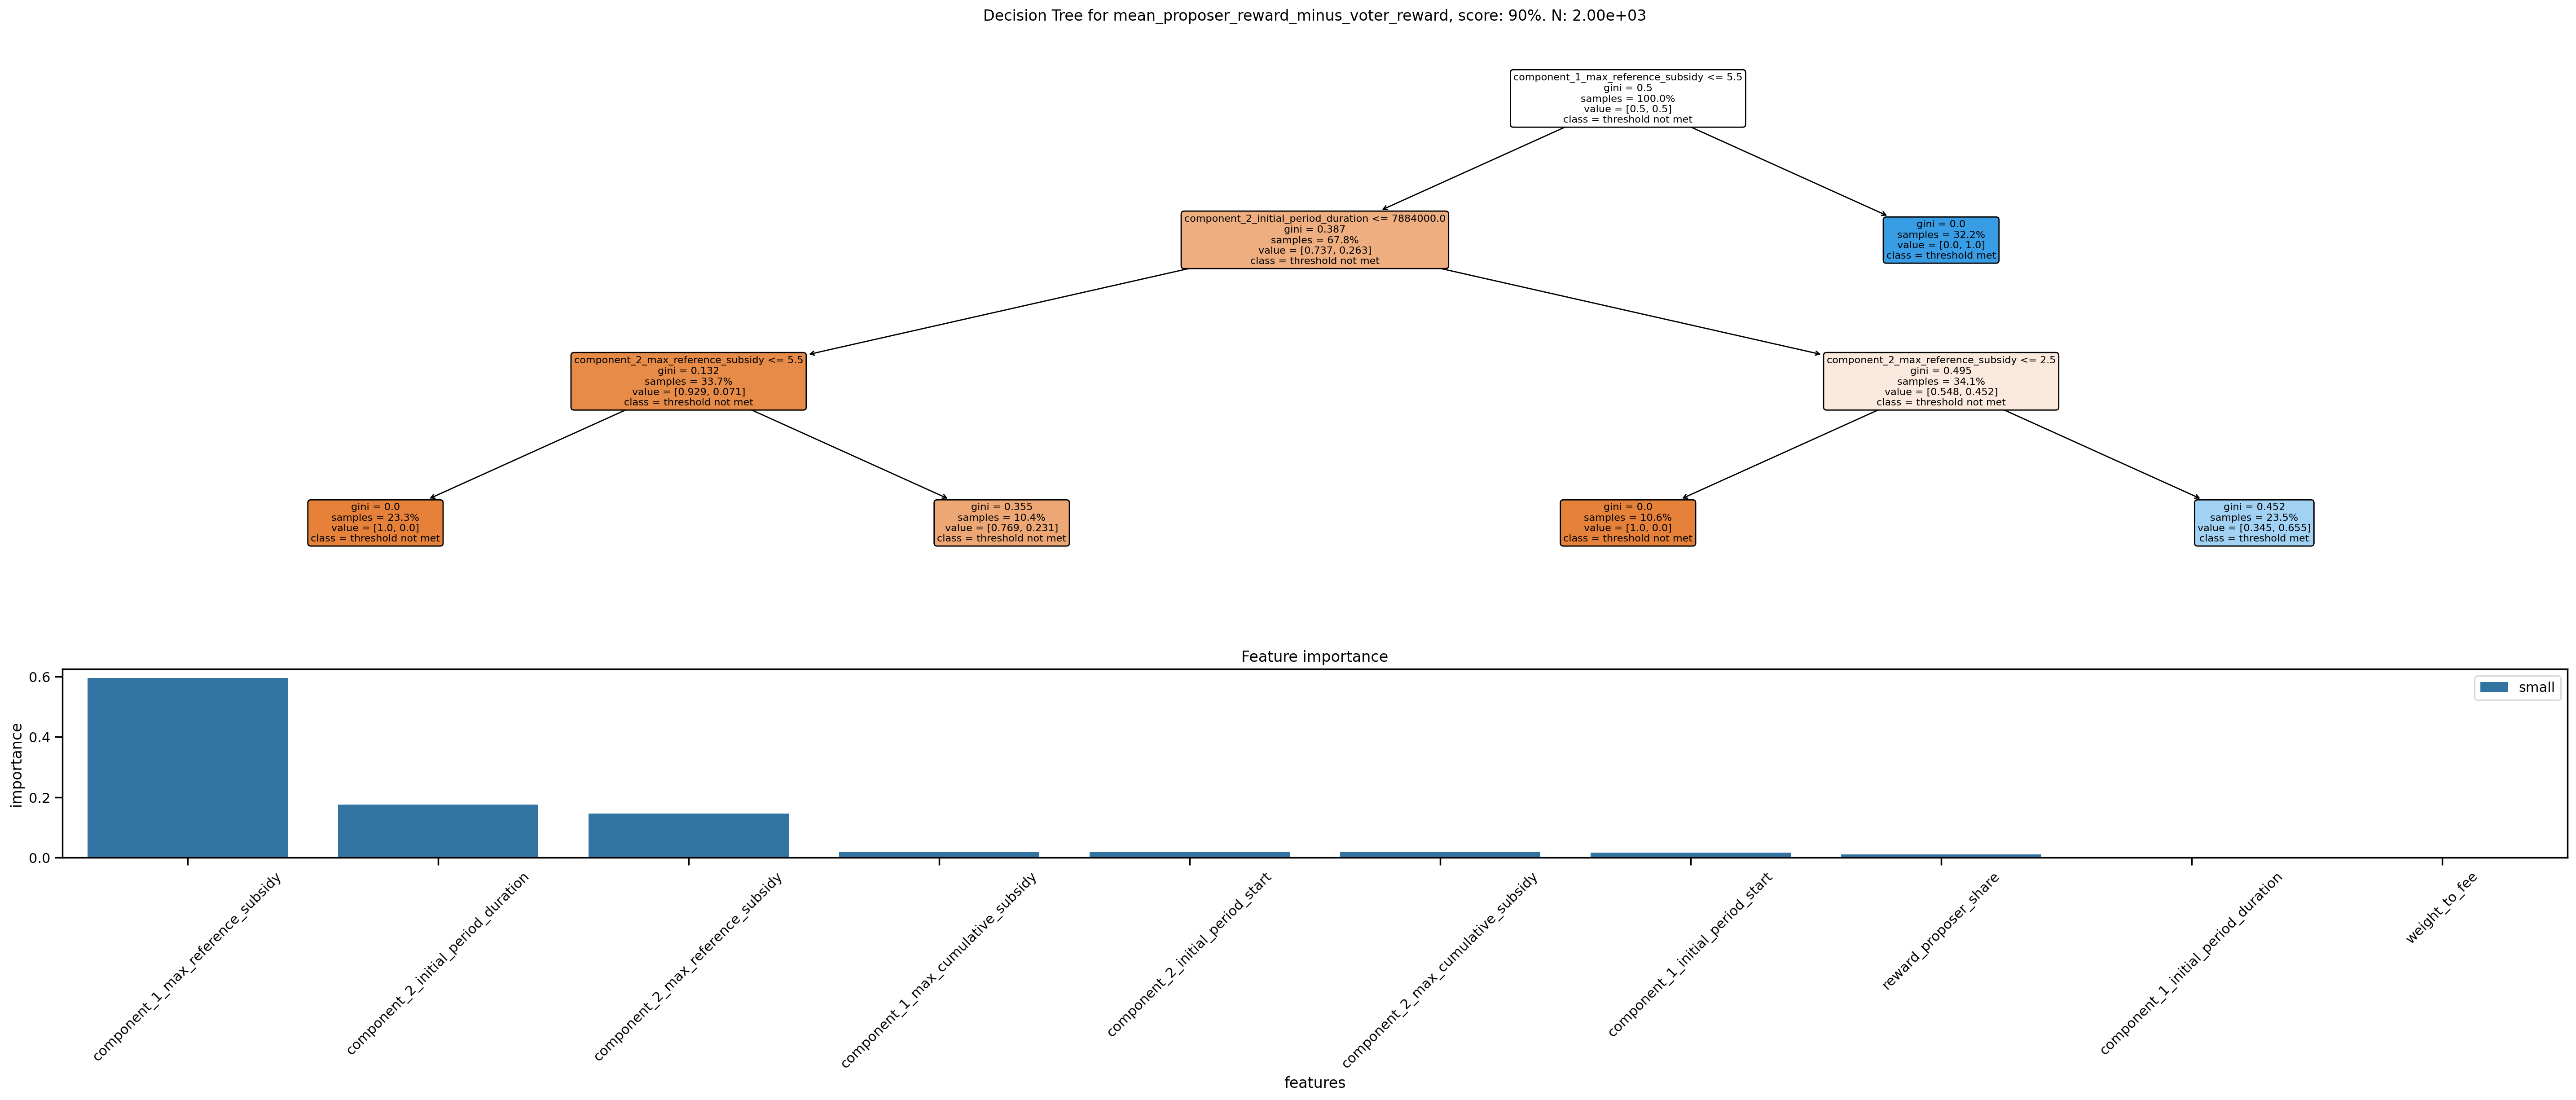

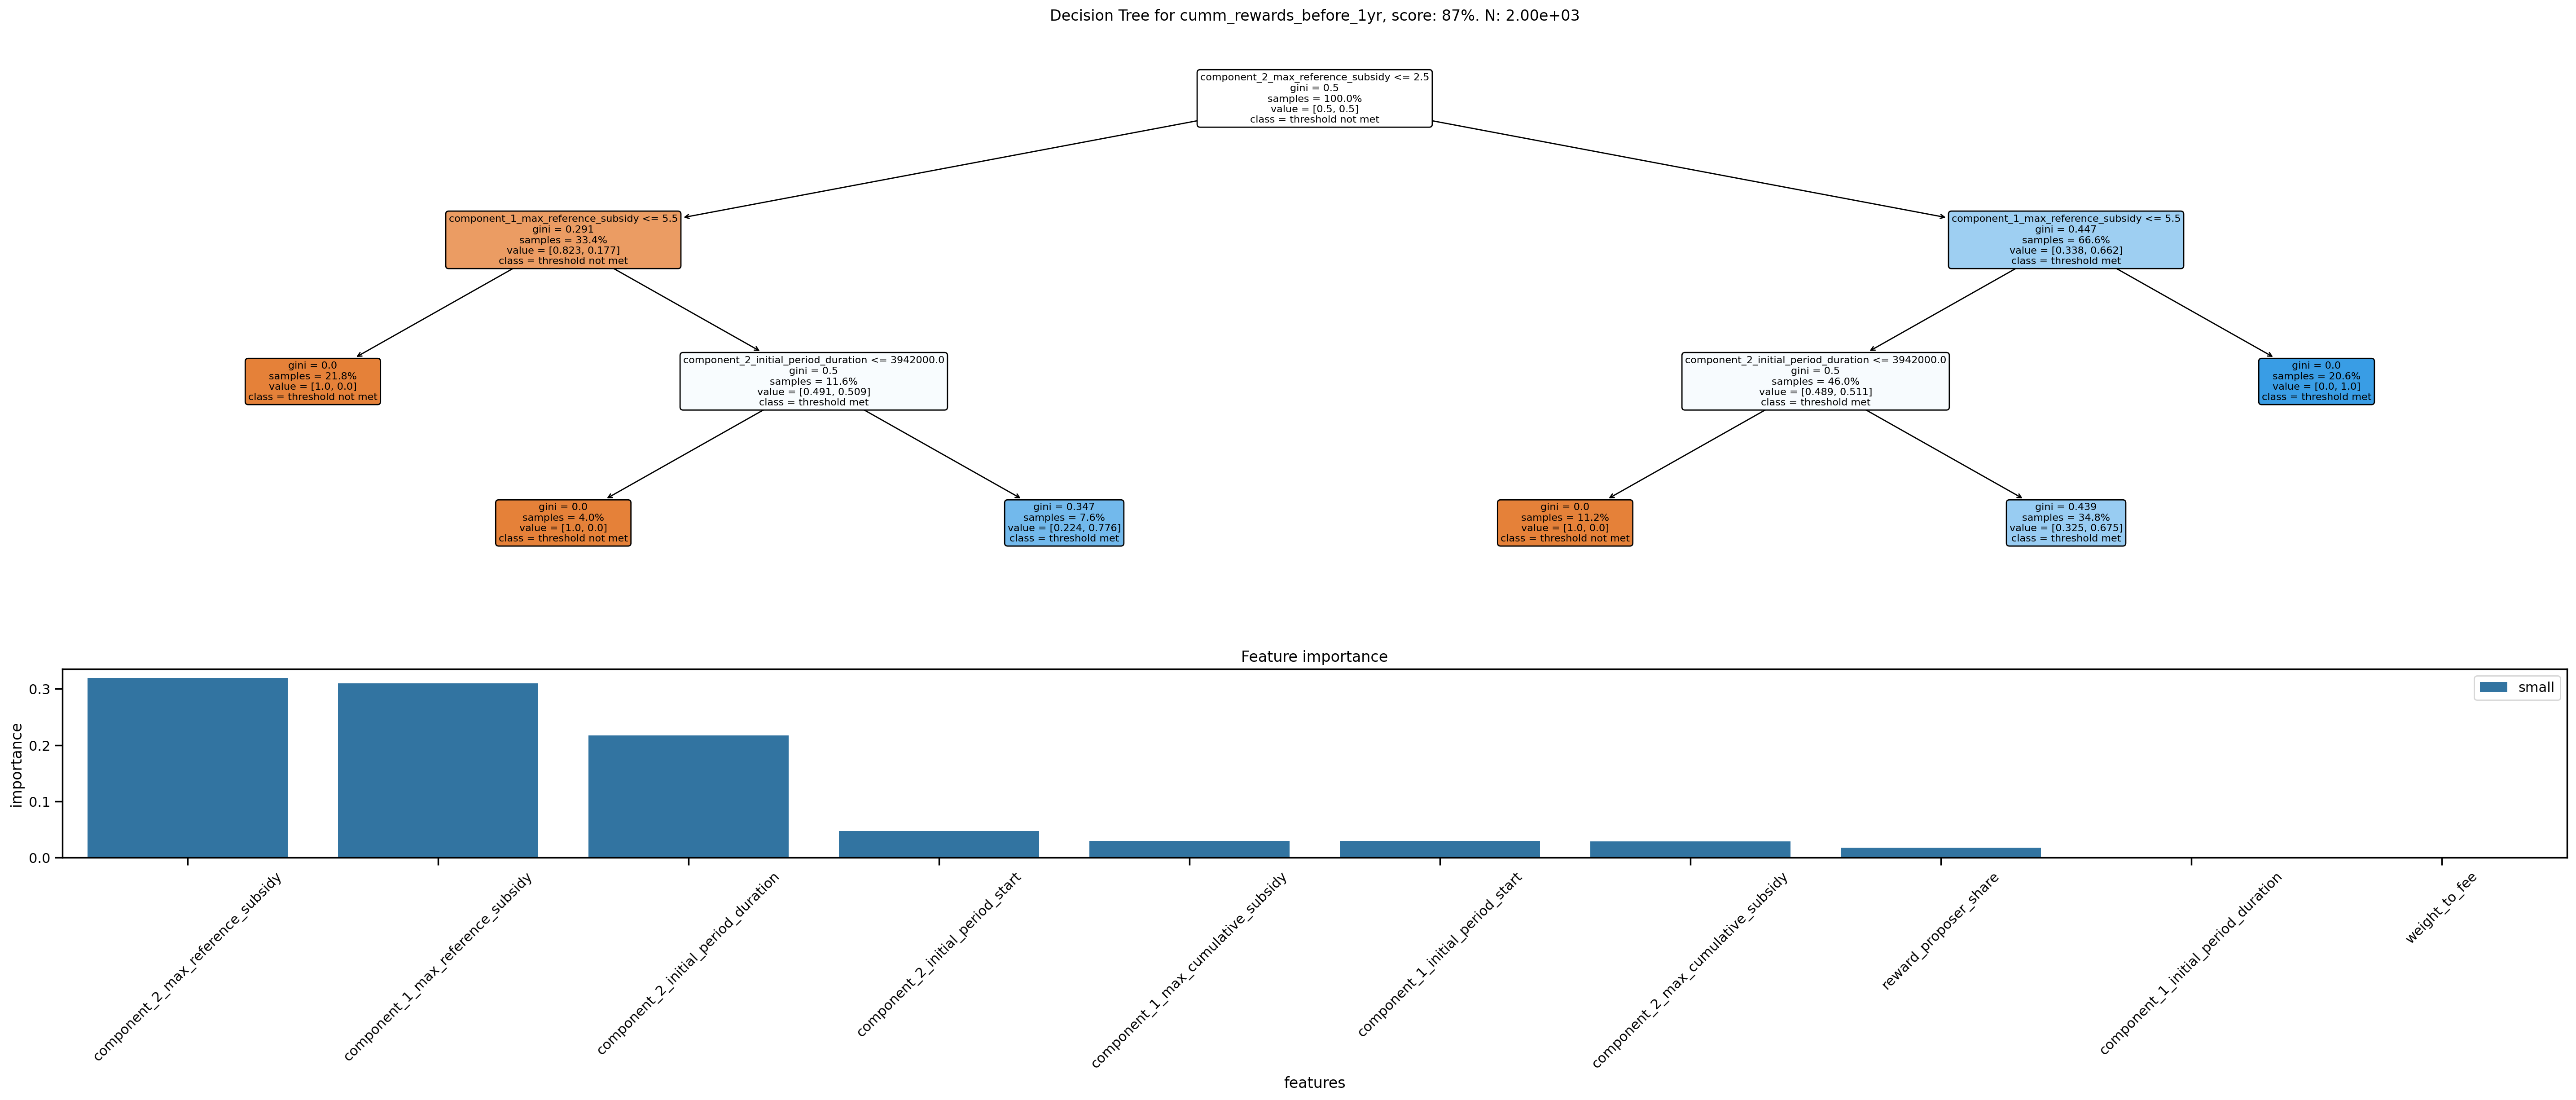

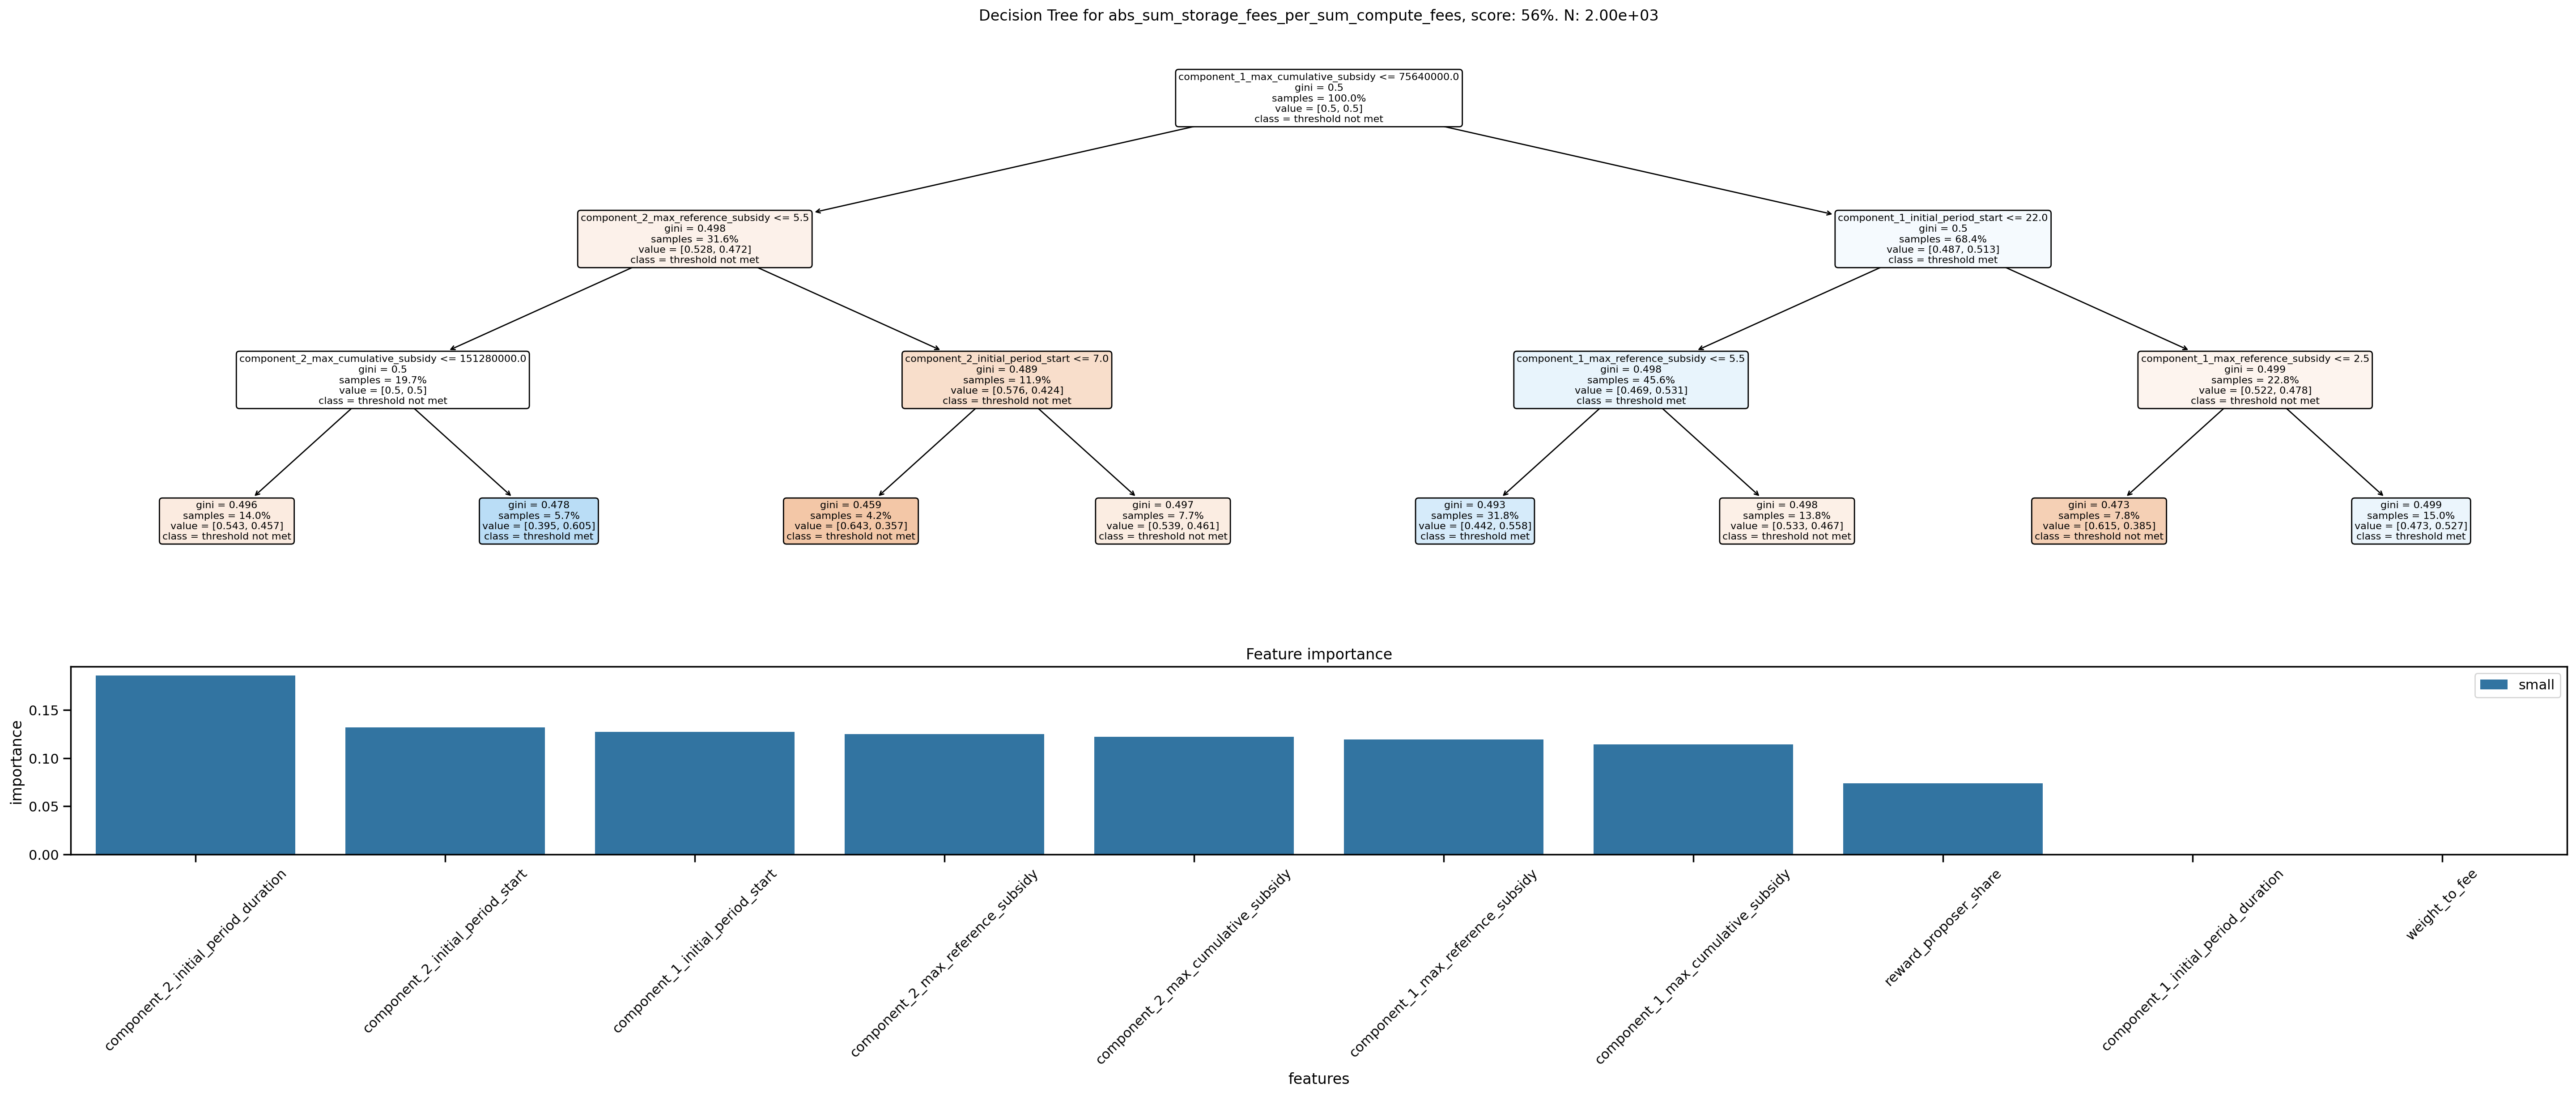

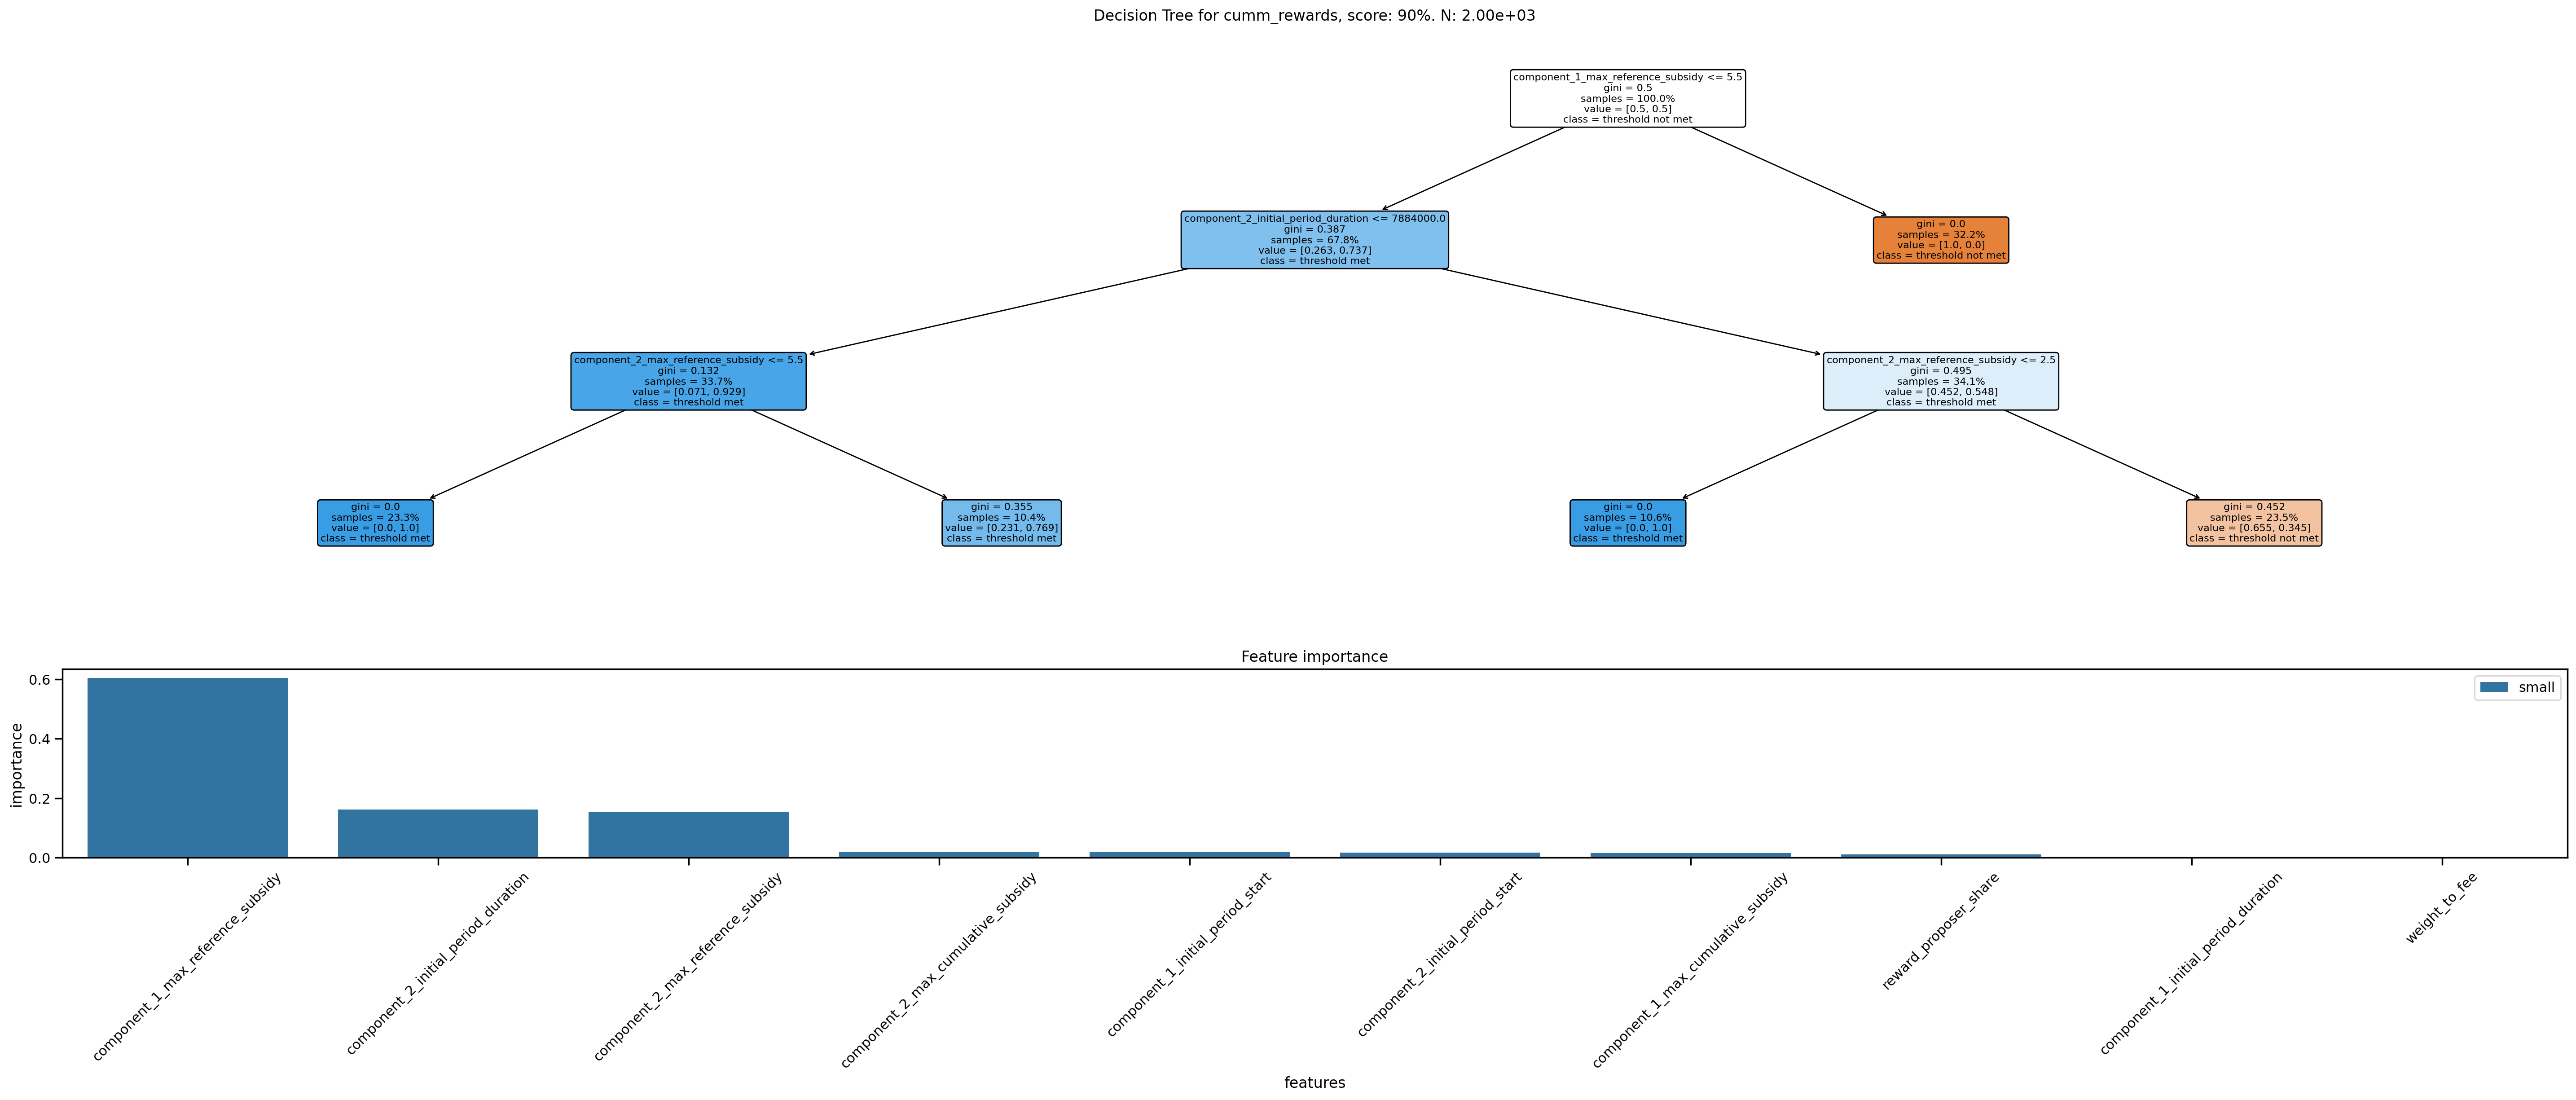

In [14]:
for col_name, (kpi_f, kpi_t) in KPI_functions.items():
    create_decision_tree_importances_plot(agg_df.reset_index(),
                                        col_name =col_name,
                                        success_criteria=kpi_t)
    plt.show()

## Parameter Impact on KPIs

In [15]:
import seaborn as sns

N_params = len(GOVERNANCE_SURFACE_PARAMS)
N_kpis = len(KPI_functions)

N_rows = N_kpis
N_cols = N_params
HEIGHT = 4.0
ASPECT = 1.5

g1 = sns.pairplot(data=agg_df.reset_index().sample(100), 
             x_vars=GOVERNANCE_SURFACE_PARAMS, 
             y_vars=list(KPI_functions.keys()),
             height=HEIGHT,
             aspect=ASPECT,
             kind='hist')


g2 = sns.pairplot(data=agg_df.reset_index().sample(100), 
             x_vars=GOVERNANCE_SURFACE_PARAMS, 
             y_vars=list(KPI_functions.keys()),
             height=HEIGHT,
             aspect=ASPECT,
             kind='reg')


In [16]:
plt.show()

In [17]:
g = g2
buf = io.BytesIO()
g.savefig(buf, format='png')
buf.seek(0)  # Go to the start of the buffer
size_bytes = len(buf.getvalue())  # Get size in bytes
buf.close()
print(f"Size of {g} plot: {int(size_bytes/1e3)}KB")

NameError: name 'g2' is not defined

In [ ]:
for k in KPI_functions.keys():
    c = agg_df.reset_index()[k].value_counts()
    if len(c) <= 10:
        print(c)

In [ ]:
d = agg_df.reset_index()[KPI_functions.keys()].describe().T
d['mean']

In [ ]:
d['std'] / d['mean']

## Conclusion